In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

## Classes used for the sampling algorithms.

In [2]:
class Proposal():
    
    def __init__(self, beta, pick):
        self.beta = beta
        self.pick = pick
    
    def get_random_variable(self, u_t):
        if self.pick == "random_walk":
            return self.random_walk(u_t).rvs()
        if self.pick == "pCN":
            return self.pCN(u_t).rvs()
        if self.pick == "random_walk_2d":
            return self.random_walk_2d(u_t).rvs()
        if self.pick == "random_walk_nd":
            return self.random_walk_nd(u_t).rvs()
        
    def get_dist(self, u_t):
        if self.pick == "random_walk":
            return self.random_walk(u_t)
        if self.pick == "pCN":
            return self.pCN(u_t)
        if self.pick == "random_walk_2d":
            return self.random_walk_2d(u_t)
        if self.pick == "random_walk_nd":
            return self.random_walk_nd(u_t)
         
    def random_walk(self, u_t):
        return stats.norm([u_t],[self.beta**2])
    
    def pCN(self, u_t):
        return stats.norm([np.sqrt(1-self.beta**2)*u_t],[2*self.beta**2])
    
    def random_walk_2d(self, u_t):
        return stats.multivariate_normal([int(u_t[0]),int(u_t[1])],[[self.beta**2,0],[0,self.beta**2]])
    
    def random_walk_nd(self, u_t):
        n = len(u_t)
        return stats.multivariate_normal(u_t, np.eye(n)*(self.beta**2))

In [3]:
# Here we define the distributions we are going to use

class Normal_Distribution():
    
    def __init__(self, mu, sigma):
        """
        mu = mean of distribution (int)
        sigma = standard deviation of distribution (int)
        """
        self.mu = mu
        self.sigma = sigma

    def pdf(self, x):
        from scipy import stats
        return stats.norm([self.mu],[self.sigma]).pdf(x)[0]
        
class Log_Normal_Distribution():
    
    def __init__(self, mu, sigma):
        """
        mu = mean of distribution (int)
        theta = standard deviation of distribution (int)
        """
        self.mu = mu
        self.sigma = sigma

    def pdf(self, x):
        from scipy import stats
        return stats.lognorm([self.sigma],loc=self.mu).pdf(x)[0]

class Gaussian_Mixture():
    
    def __init__(self, pi_s):
        """
        pi_s = pi_s is a list of normal distributions made with stats.norm([mu],[sigma])
        """
        self.pi_s = pi_s

    def pdf(self, x):
        """
        x is the value we want to evaluate
        """
        return sum([pi.pdf(x) for pi in self.pi_s])
    
# n-Dimensional distribtions we wish to explore
class Multivariate_Gaussian():
    
    def __init__(self, mu, covariance):
            """
            mu = mean of distribution (list of int). Example: [10,5]
            covariance = covariance matrix (list of lists of int). Example: [[1,0],[0,1]]
            """
            self.mu = mu
            self.covariance = covariance

    def pdf(self, x):
        from scipy import stats
        return stats.multivariate_normal(self.mu,self.covariance).pdf(x)

class Rosenbrook_2D_Function():
    
    def __init__(self, coef_1, coef_2):
            self.coef_1 = coef_1
            self.coef_2 = coef_2
    
    def pdf(self, x):
        a = (x[1]-(x[0]**2))**2
        b = (1-x[1])**2
        return np.exp(-self.coef_1*(a+b)/self.coef_2)

In [4]:
class Sampler():
    
    def __init__(self, beta, N, dimension, target_distribution, proposal,alpha=1):
        self.alpha = alpha
        self.beta = beta
        self.N = N
        self.dimension = dimension
        self.proposal = proposal
        self.target_distribution = target_distribution
    
    def Reversible_Metropolis_Hastings_Algo(self):
        """
        Implementation of Metropolis Hastings Algorithm.
        """
        # initalize
        if self.dimension == 1:
            u_0 = 0
            u_t = 0
        else: 
            u_0 = list(np.zeros(self.dimension))
            u_t = list(np.zeros(self.dimension))

        samples = [u_0]
        list_acceptance_probaility = []
        
        posterior_distribution = self.target_distribution
        proposal = self.proposal

        for t in range(self.N):

            # sample a proposal u′ from density q(u′|u(t)) 
            u_prime = proposal.get_random_variable(u_t)

            # proposal density q(u(t)|u′) and q(u′|u(t)) used in (3)
            proposal_density_prime = proposal.get_dist(u_prime)
            proposal_density_t = proposal.get_dist(u_t)

            # π(u′)q(u(t)|u′)
            numerator = posterior_distribution.pdf(u_prime)*proposal_density_prime.pdf(u_t)
            # π(u(t))q(u′|u(t))
            denominator = posterior_distribution.pdf(u_t)*proposal_density_t.pdf(u_prime)

            if numerator == 0:
                acceptance_probaility = 0
            elif denominator == 0:
                acceptance_probaility = 1
            else:
                acceptance_probaility = float(min([1,numerator/denominator]))
            
            list_acceptance_probaility.append(acceptance_probaility)

            rv = np.random.uniform(0,1,1)

            if rv <= acceptance_probaility:
                #Accept
                u_t = u_prime
                samples.append(u_t)
            else:
                #Reject
                u_t = u_t
                samples.append(u_t)
    
        return samples, list_acceptance_probaility
        
    def Non_Reversible_Metropolis_Hastings_Algo(self):
        # initalize
        u_0 = 1
        u_t = 1
            
        samples = [u_0]
        list_acceptance_probaility = []
        
        posterior_distribution = self.target_distribution

        rv_z = np.random.uniform(0,1,1)
        z = 0 
        if rv_z < 0.5:
            z = 1
        else:
            z = -1
        
        alpha = self.alpha
        beta = self.beta
        gamma_distribution = stats.gamma(a=alpha, scale=1/beta)

        # zi=yi+γ·yip,γ∼Γ(α,β);

        for t in range(self.N):

            if z > 0: 

                # sample a proposal u′ from density f(u′|u(t))
                u_prime = u_t + gamma_distribution.rvs()

                # π(u′)g(u(t)|u′)
                numerator = posterior_distribution.pdf(u_prime)*gamma_distribution.pdf(u_prime - u_t)

                # π(u(t))f(u′|u(t))
                denominator = posterior_distribution.pdf(u_t)*gamma_distribution.pdf(u_prime - u_t)
                
                if numerator == 0:
                    acceptance_probaility = 0
                elif denominator == 0:
                    acceptance_probaility = 1
                else:
                    acceptance_probaility = float(min([1,numerator/denominator]))

                list_acceptance_probaility.append(acceptance_probaility)

            else:

                # sample a proposal u′ from density g(u′|u(t))
                u_prime = u_t - gamma_distribution.rvs()

                # π(u′)f(u(t)|u′)
                numerator = posterior_distribution.pdf(u_prime)*gamma_distribution.pdf(u_t - u_prime)

                # π(u(t))g(u′|u(t))
                denominator = posterior_distribution.pdf(u_t)*gamma_distribution.pdf(u_t - u_prime)

                if numerator == 0:
                    acceptance_probaility = 0
                elif denominator == 0:
                    acceptance_probaility = 1
                else:
                    acceptance_probaility = float(min([1,numerator/denominator]))

                list_acceptance_probaility.append(acceptance_probaility)

            rv = np.random.uniform(0,1,1)

            if rv <= acceptance_probaility:
                #Accept
                u_t = u_prime
                samples.append(u_t)
                z = z 
            else:
                #Reject
                u_t = u_t
                samples.append(u_t)
                z = -1*z

        return samples, list_acceptance_probaility
    
    def Non_Reversible_Metropolis_Hastings_High_Dimensions(self, period):
        # initalize
        u_0 = list(np.zeros(self.dimension))
        u_t = list(np.zeros(self.dimension))

        direction_vectors = np.eye(self.dimension)
        #Pick a random direction
        y_p = direction_vectors[np.random.randint(self.dimension)]

        samples = [u_0]
        list_acceptance_probaility = []

        posterior_distribution = self.target_distribution

        rv_z = np.random.uniform(0,1,1)
        z = 0 
        if rv_z < 0.5:
            z = 1
        else:
            z = -1

        def sgn(eta,y_p):
            x = np.dot(eta,y_p)
            if x >= 0:
                return 1
            else:
                return -1

        multivariate_normal = stats.multivariate_normal(np.zeros(self.dimension),np.eye(self.dimension))

        def f_pdf(z, y, y_p):
            x = np.dot(y_p,z-y)
            if x >= 0:
                return (2/(2*np.pi)**(self.dimension/2)*np.exp((-1/2)*np.linalg.norm(z-y)**2))
            else:
                return 0 

        def g_pdf(z, y, y_p):
            x = np.dot(y_p,z-y)
            if x >= 0:
                return 0
            else:
                return (2/(2*np.pi)**(self.dimension/2)*np.exp((-1/2)*np.linalg.norm(z-y)**2))

        for t in range(self.N):
            
            # Change direction y_p periodically
            if t%period == 0:
                y_p = direction_vectors[np.random.randint(self.dimension)]

            if z > 0: 
                
                eta = multivariate_normal.rvs()
                # sample a proposal u′ from density f(u′|u(t))
                u_prime = u_t + sgn(eta,y_p)*eta

                # π(u′)g(u(t)|u′)
                numerator = posterior_distribution.pdf(u_prime)*g_pdf(u_t,u_prime, y_p)

                # π(u(t))f(u′|u(t))
                denominator = posterior_distribution.pdf(u_t)*f_pdf(u_prime, u_t, y_p)

                acceptance_probaility = float(min([1,numerator/denominator]))
                list_acceptance_probaility.append(acceptance_probaility)

            else:
                
                eta = multivariate_normal.rvs()
                # sample a proposal u′ from density g(u′|u(t))
                u_prime = u_t - sgn(eta,y_p)*eta

                # π(u′)f(u(t)|u′)
                numerator = posterior_distribution.pdf(u_prime)*f_pdf(u_t,u_prime, y_p)

                # π(u(t))g(u′|u(t))
                denominator = posterior_distribution.pdf(u_t)*g_pdf(u_prime, u_t, y_p)

                acceptance_probaility = float(min([1,numerator/denominator]))
                list_acceptance_probaility.append(acceptance_probaility)

            rv = np.random.uniform(0,1,1)

            if rv <= acceptance_probaility:
                #Accept
                u_t = u_prime
                samples.append(u_t)
                z = z 
            else:
                #Reject
                u_t = u_t
                samples.append(u_t)
                z = -1*z

        return samples, list_acceptance_probaility


In [613]:
# Example of how to use these classes above.
normal_dist = Multivariate_Gaussian([10,2],[[1,0],[0,1]])
proposal = Proposal(beta=2.3, pick="random_walk_2d")
sampler = Sampler(beta = 2.3, N = 10, dimension=2, target_distribution=normal_dist, proposal=proposal)

a, b = sampler.Reversible_Metropolis_Hastings_Algo()

In [614]:
normal_dist = Normal_Distribution(10,2)
proposal = Proposal(beta=2.3, pick="random_walk")
sampler = Sampler(beta = 2.3, N = 10, dimension=1, target_distribution=normal_dist, proposal=proposal)

a, b = sampler.Reversible_Metropolis_Hastings_Algo()

## Class that is used for the analysis of the variance

In [5]:
class Variance_Analysis():
    
    def __init__(self, list_samples):
        """
        list_samples, a list of the samples.
        """
        self.list_samples = list_samples
        self.N = len(self.list_samples)

    def c_tau(self, tau):
        """
        𝜌𝑓(𝜏) is the normalized autocorrelation function
        p 𝑓(𝜏)=p𝑓(𝜏)/p 𝑓(0)
        """

        u_mean = np.mean(self.list_samples)
        N = self.N
        summ = sum([np.dot((self.list_samples[i]-u_mean),(self.list_samples[i+tau]-u_mean)) for i in range(0,self.N-tau)])

        return (1/(self.N-tau))*summ

   
    def autocorrelation_M(self, M):
        """
        integrated autocorrelation time : 1+2∑𝜏=1𝑁𝜌̂ 𝑓(𝜏)
        autocorrelation = 1 + 2*sum(pf(tau))
        Note that U_i's are sampled from the posterior distribution pi we are trying to model.

        This function you can change to what value of M you should be able to add too, that is the different lags.
        """ 
        c_0 = self.c_tau(0)
        return 1 + 2*sum([self.c_tau(i)/c_0 for i in range(1,M+1)])
    
    def asymptotic_variance(self, M):
        
        u_0 = self.list_samples[0]

        u_variance = np.var(self.list_samples)

        return u_variance + 2*sum([self.c_tau(i) for i in range(1,M+1)])

    def variance_of_estimator(self, M):
        return self.asymptotic_variance(M)/self.N


## This is to produce graphs

In [6]:
class Graph_Maker():
    
    def __init__(self, samples):
        self.samples = samples
        self.N = len(samples)
    
    def plot_samples(self, title):
        
        sample_index = [i for i in range(self.N)]
        
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.plot(sample_index,self.samples)
        ax.scatter(sample_index,self.samples)

        ax.set_ylabel('Sample value')
        ax.set_xlabel('Sample index')
        ax.set_title(title)
                
    def plot_1D_gaussian(self, mean, sd, burn_in, title):
        
        if burn_in == True:
            
            sample_index = [i for i in range(self.N)]

            fig, ax = plt.subplots(figsize=(20, 10))
            ax.plot(sample_index,self.samples)
            ax.scatter(sample_index,self.samples)
            
            index = 0 
            for u in samples:
                index+=1
                if(u > mean-2*sd):
                    break

            ax.vlines(index, 0, 14.5, "g",'--',label = "First value of u_t = u_{} which is in Mean +- 2*s_d".format(index))
        
            ax.hlines(mean, 0, len(samples), "r",label = "Mean of underlying postierior distriution pi")
            ax.hlines(mean-2*sd, 0, self.N, "b",'--',label = "Mean +- 2*s_d")
            ax.hlines(mean+2*sd, 0, self.N, "b",'--')

            ax.set_ylabel('Sample value')
            ax.set_xlabel('Sample index')
            ax.set_title(title)
            ax.legend()
            
        else:
        
            sample_index = [i for i in range(self.N)]

            fig, ax = plt.subplots(figsize=(20, 10))
            ax.plot(sample_index,self.samples)
            ax.scatter(sample_index,self.samples)

            ax.hlines(mean, 0, len(samples), "r",label = "Mean of underlying postierior distriution pi")
            ax.hlines(mean-2*sd, 0, self.N, "b",'--',label = "Mean +- 2*s_d")
            ax.hlines(mean+2*sd, 0, self.N, "b",'--')

            ax.set_ylabel('Sample value')
            ax.set_xlabel('Sample index')
            ax.set_title(title)
            ax.legend()
    
    def plot_multivariate_gaussian(self, mean, sd, burn_in, title):
        
        if burn_in == True:
            
            sample_index = [i for i in range(self.N)]

            fig, ax = plt.subplots(figsize=(20, 10))
            ax.plot(sample_index,self.samples)
            ax.scatter(sample_index,self.samples)
            
            index = 0 
            for u in samples:
                index+=1
                if(u > mean_1-2*sd or u > mean_2-2*sd):
                    break

            ax.vlines(index, 0, 14.5, "g",'--',label = "First value of u_t = u_{} which is in Mean_2 +- 2*s_d".format(index))

            ax.hlines(mean[0], 0, self.N, "r",label = "Mean of underlying postierior distriution pi")
            ax.hlines(mean[0]-2*sd[0], 0, self.N, "b",'--',label = "Mean +- 2*s_d")
            ax.hlines(mean[0]+2*sd[0], 0, self.N, "b",'--')

            ax.hlines(mean[1], 0, self.N, "b",label = "Mean of underlying pi 2")
            ax.hlines(mean[1]-2*sd[1], 0, self.N, "b",'--') 
            ax.hlines(mean[1]+2*sd[1], 0, self.N, "b",'--')

            ax.set_ylabel('Sample value')
            ax.set_xlabel('Sample index')
            ax.set_title(title)
            ax.legend()
            
        else:
            
            sample_index = [i for i in range(self.N)]

            fig, ax = plt.subplots(figsize=(20, 10))
            ax.plot(sample_index,self.samples)
            ax.scatter(sample_index,self.samples)

            ax.hlines(mean[0], 0, self.N, "r",label = "Mean of underlying postierior distriution pi")
            ax.hlines(mean[0]-2*sd[0], 0, self.N, "b",'--',label = "Mean +- 2*s_d")
            ax.hlines(mean[0]+2*sd[0], 0, self.N, "b",'--')

            ax.hlines(mean[1], 0, self.N, "b",label = "Mean of underlying pi 2")
            ax.hlines(mean[1]-2*sd[1], 0, self.N, "b",'--') 
            ax.hlines(mean[1]+2*sd[1], 0, self.N, "b",'--')

            ax.set_ylabel('Sample value')
            ax.set_xlabel('Sample index')
            ax.set_title(title)
            ax.legend()
    
    def plot_2D(self,title):
        x = [s[0] for s in self.samples]
        y = [s[1] for s in self.samples]
        sample_chosen_index = [i for i in range(self.N)]

        fig, ax = plt.subplots(figsize=(20, 10))
        ax.set_ylabel('Y')
        ax.set_xlabel('X')
        ax.set_title(title)
        ax.scatter(x,y,c=sample_chosen_index)
    
    def plot_histogram(self, title):
        fig, ax = plt.subplots(figsize=(20, 10))
        plt.hist(self.samples,density=True,bins=50)
        ax.set_title(title)

In [7]:
def finding_beta(beta_s, list_average_acceptance_probabity, title):
        """
        beta_s = list of betas you are using to compare
        list_average_acceptance_probabity = list of average acceptance probability 
        
        Used for tuning the beta parameter for the proposal distribtions
        
        EXAMPLE:
        beta_s = [x/10 for x in range(101)]
        list_a_p = []
        N = 1000 

        for beta in beta_s:
            average_acceptance_probabity = expected_value_sampling(MH_A_1D(beta,N,proposed_density_random_walk)[1])
            list_a_p.append(average_acceptance_probabity)
        """
        
        fig, ax = plt.subplots(figsize=(20, 10))
        plt.scatter(beta_s,list_average_acceptance_probabity)
        ax.hlines(.234, 0, beta_s[-1], "r",label = "Desired average acceptance probability")
        ax.set_ylabel('Average acceptance probability')
        ax.set_xlabel('Beta')
        ax.set_title(title)
        ax.legend()


In [8]:
def finding_M(M_s, asy_Var_M_s, title):
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.scatter(M_s,asy_Var_M_s)
    
    ax.set_title(title)
    ax.set_ylabel('Autocorrelation $tau$')
    ax.set_xlabel('M')

In [9]:
def compare_proposals(N_s, variances_RW, variances_pCN, title):
    """
    EXAMPLE:
    #Compare the asymptotic variance for the 2 estimators
    N_s = [i for i in range(100,4000,100)]
    variances_pCN = []
    variances_RW = []

    for N in N_s:
        asymp_var = asymptotic_variance(MH_A_1D(2.1,N,proposed_density_random_walk)[0])
        var_estimator = asymp_var/N
        variances_RW.append(var_estimator)

    for N in N_s:
        asymp_var = asymptotic_variance(MH_A_1D(0.5,N,proposed_density_pCN)[0])
        var_estimator = asymp_var/N
        variances_pCN.append(var_estimator)
    """
    
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.scatter(N_s, variances_RW, label = "Random Walk")
    plt.scatter(N_s, variances_pCN, label = "pCN")

    ax.set_ylabel('Variance of Estimator')
    ax.set_xlabel('Number of samples')
    ax.set_title(title)
    ax.legend()

def show_variance(N_s, variance, title):
    
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.scatter(N_s, variance)
    plt.grid(True)

    ax.set_ylabel('Variance of Estimator')
    ax.set_xlabel('Number of samples')
    ax.set_title(title)
    
    ax.legend()

In [10]:
class Compare_Reversible_Non_Reversible():
    
    def __init__(self, samples_reverible, samples_non_reversible):
        self.samples_reverible = samples_reverible
        self.samples_non_reversible = samples_non_reversible
    
    def compare_lags(self, max_lag):
        
        variance_analysis_r = Variance_Analysis(self.samples_reverible)
        variance_analysis_non_r = Variance_Analysis(self.samples_non_reversible)

        covariance_reversible = [variance_analysis_r.c_tau(i) for i in range(max_lag)]
        covariance_non_reversible = [variance_analysis_non_r.c_tau(i) for i in range(max_lag)]

        lag_reversible = [i for i in range(max_lag)]
        lag_non_reversible = [i for i in range(max_lag)]

        fig, ax = plt.subplots(figsize=(20, 10))
        plt.scatter(lag_reversible,covariance_reversible,label = "Reversible Sampler")
        plt.scatter(lag_non_reversible,covariance_non_reversible,label = "Non-Reversible Sampler")

        ax.set_ylabel('Covariance')
        ax.set_xlabel('Lag')
        ax.legend()

## Analysis 

### 1 - Finding Beta for our problem, an example.

In [576]:
normal_dist = Normal_Distribution(10,2)

beta_s = [x/10 for x in range(60)]
list_a_p = []

for beta in beta_s:
    proposal = Proposal(beta = beta, pick = "random_walk")
    sampler = Sampler(beta = beta, N = 1000, dimension = 1, target_distribution=normal_dist, proposal=proposal)
    _, a = sampler.Reversible_Metropolis_Hastings_Algo()
    average_acceptance_probabity = np.mean(a)
    list_a_p.append(average_acceptance_probabity)


/Users/lorenzostigliano/Documents/University/4th_Year/Maths_Project/Notebook/env/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1760: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


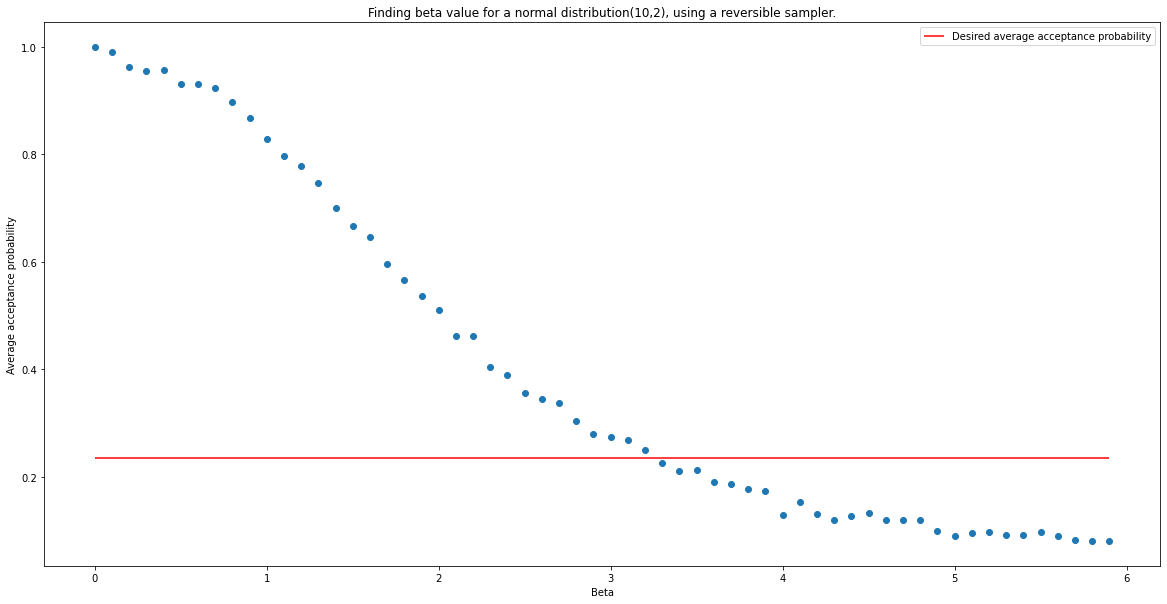

In [577]:
finding_beta(beta_s, list_a_p, "Finding beta value for a normal distribution(10,2), using a reversible sampler.")

In [592]:
normal_dist = Normal_Distribution(10,2)

beta_s = list(np.linspace(0,2,21))
list_a_p = []

for beta in beta_s:
    proposal = Proposal(beta = beta, pick = "random_walk")
    sampler = Sampler(beta = beta, N = 1000, dimension = 1, target_distribution=normal_dist, proposal=proposal)
    _, a = sampler.Non_Reversible_Metropolis_Hastings_Algo()
    average_acceptance_probabity = np.mean(a)
    list_a_p.append(average_acceptance_probabity)


<ipython-input-536-4aa64624169c>:84: RuntimeWarning: divide by zero encountered in double_scalars
  gamma_distribution = stats.gamma(a=alpha, scale=1/beta)
<ipython-input-536-4aa64624169c>:96: RuntimeWarning: invalid value encountered in double_scalars
  numerator = posterior_distribution.pdf(u_prime)*gamma_distribution.pdf(u_prime - u_t)
<ipython-input-536-4aa64624169c>:99: RuntimeWarning: invalid value encountered in double_scalars
  denominator = posterior_distribution.pdf(u_t)*gamma_distribution.pdf(u_prime - u_t)


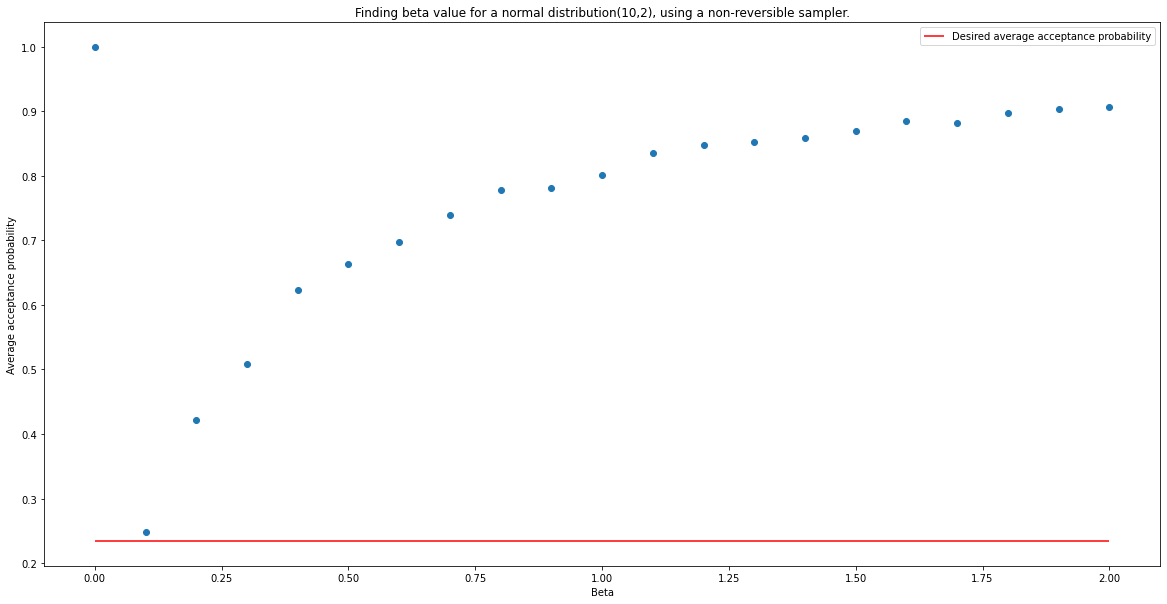

In [593]:
finding_beta(beta_s, list_a_p, "Finding beta value for a normal distribution(10,2), using a non-reversible sampler.")

### 2a - Finding M for Autocorrelation function to see how correlated our samples. 

In [508]:
normal_dist = Normal_Distribution(10,2)
proposal = Proposal(beta = 3.2, pick = "random_walk") 
sampler = Sampler(beta = 3.2, N = 4000, dimension = 1, target_distribution=normal_dist, proposal=proposal)
samples, _ = sampler.Reversible_Metropolis_Hastings_Algo()
    
M_s = range(1,len(samples),100)
asy_Var_M_s = []
variance_analysis = Variance_Analysis(samples)

for M in M_s:
    value = variance_analysis.autocorrelation_M(M)
    asy_Var_M_s.append(value)

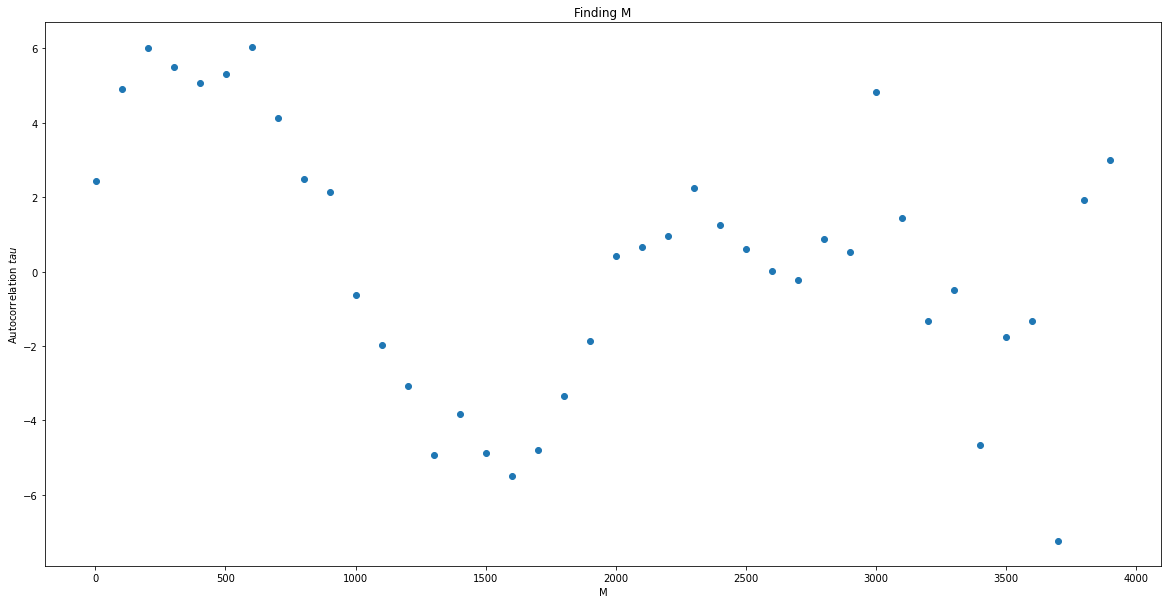

In [509]:
finding_M(M_s, asy_Var_M_s, "Finding M")

### 2b - Autocorreltation function to see how correlated our samples. Show how the variance of the estimator decreases as the number of samples increase.

In [472]:
N_s = [i for i in range(400,4000,200)]
variances = []

normal_dist = Normal_Distribution(10,2)
proposal = Proposal(beta = 3.2, pick = "random_walk")


for N in N_s:
    
    sampler = Sampler(beta = 3.2, N = N, dimension = 1, target_distribution=normal_dist, proposal=proposal)
    samples, _ = sampler.Reversible_Metropolis_Hastings_Algo()
    
    variance_analysis = Variance_Analysis(samples)
    variances.append(variance_analysis.variance_of_estimator(200))
    print(N,variance_analysis.variance_of_estimator(200))

400 -0.01051705354914081
600 0.01571500993563823
800 0.00435938246587773
1000 0.09627128291151732
1200 0.022755410176117655
1400 0.006039360011323732
1600 0.001675956170491706
1800 0.007824691840845674
2000 0.0140956269401124
2200 -0.0007333302502296757
2400 0.0014751933706141068
2600 0.004233383991395626
2800 0.001957542082576685
3000 0.005874171914196821
3200 0.0069393913947195
3400 0.009323634281548721
3600 0.0033080362564206814
3800 0.004228162695858098


No handles with labels found to put in legend.


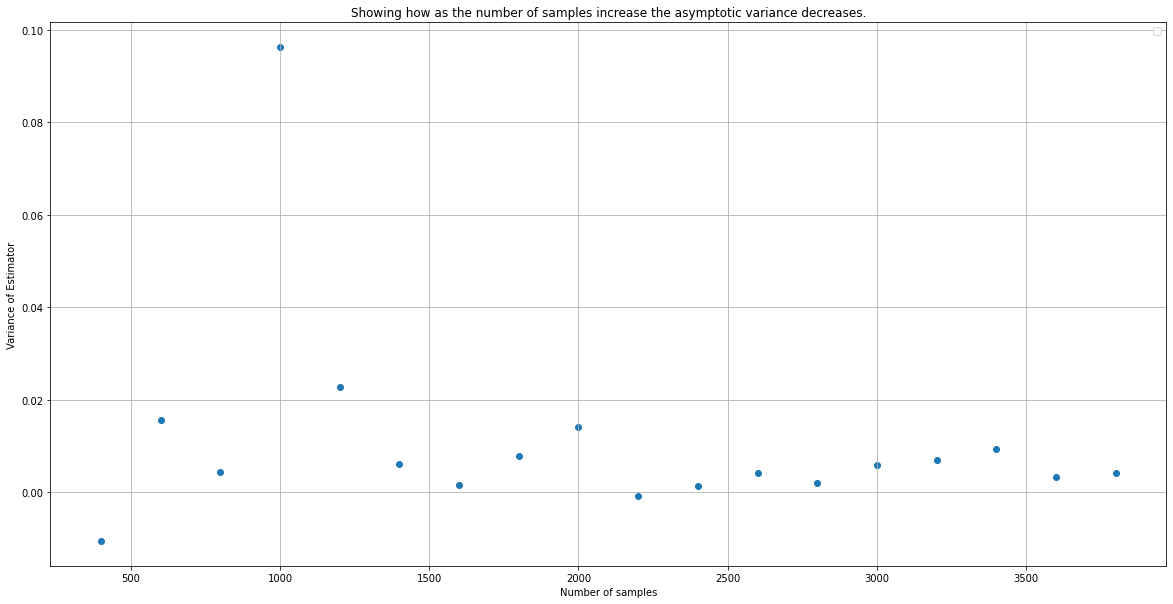

In [474]:
show_variance(N_s, variances, "Showing how as the number of samples increase the asymptotic variance decreases.")

### 3 -  Finding Burn-in by ploting samples sample against sample number

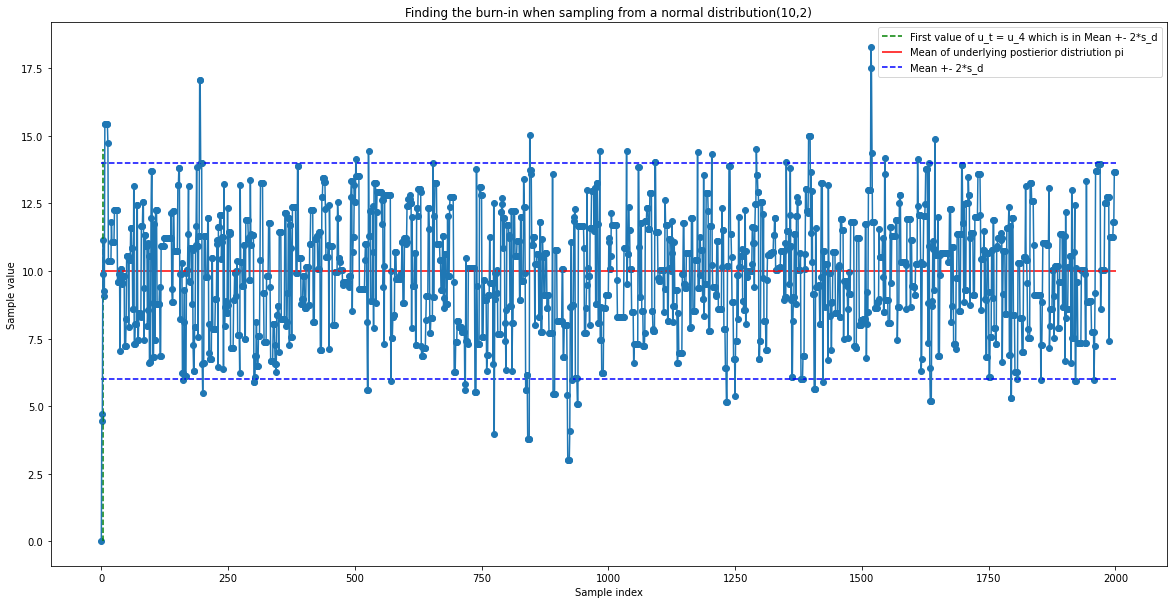

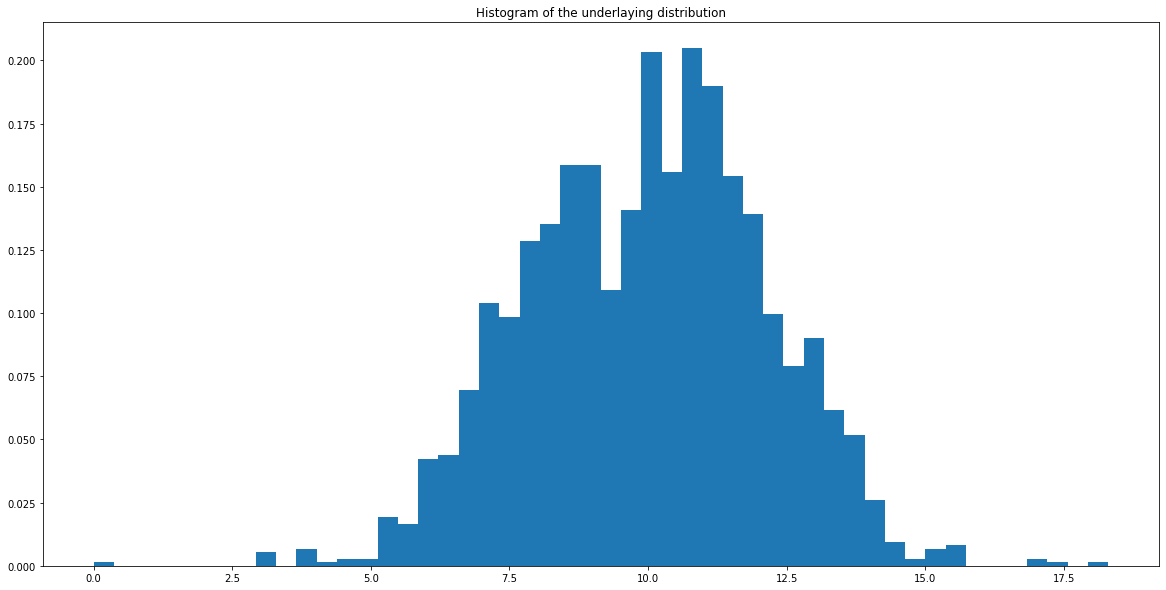

In [210]:
normal_dist = Normal_Distribution(10,2)
proposal = Proposal(beta = 2.3, pick = "random_walk")
sampler = Sampler(beta = 2.3, N = 2000, dimension = 1, target_distribution=normal_dist, proposal=proposal)

samples, _ = sampler.Reversible_Metropolis_Hastings_Algo()

graph_maker = Graph_Maker(samples)
graph_maker.plot_1D_gaussian(10,2,True,"Finding the burn-in when sampling from a normal distribution(10,2)")

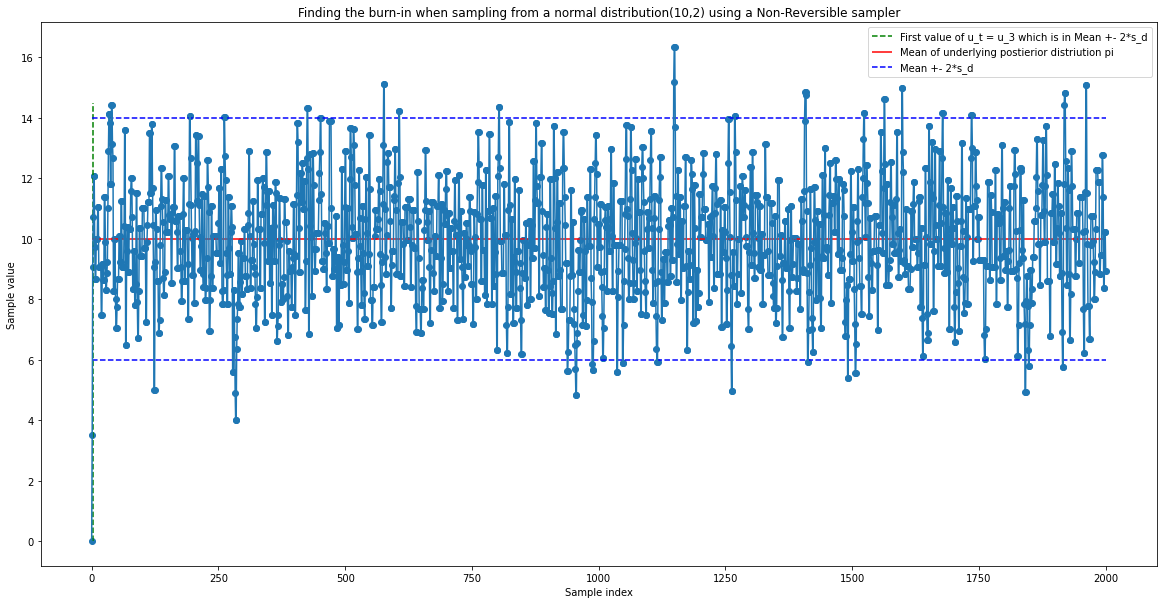

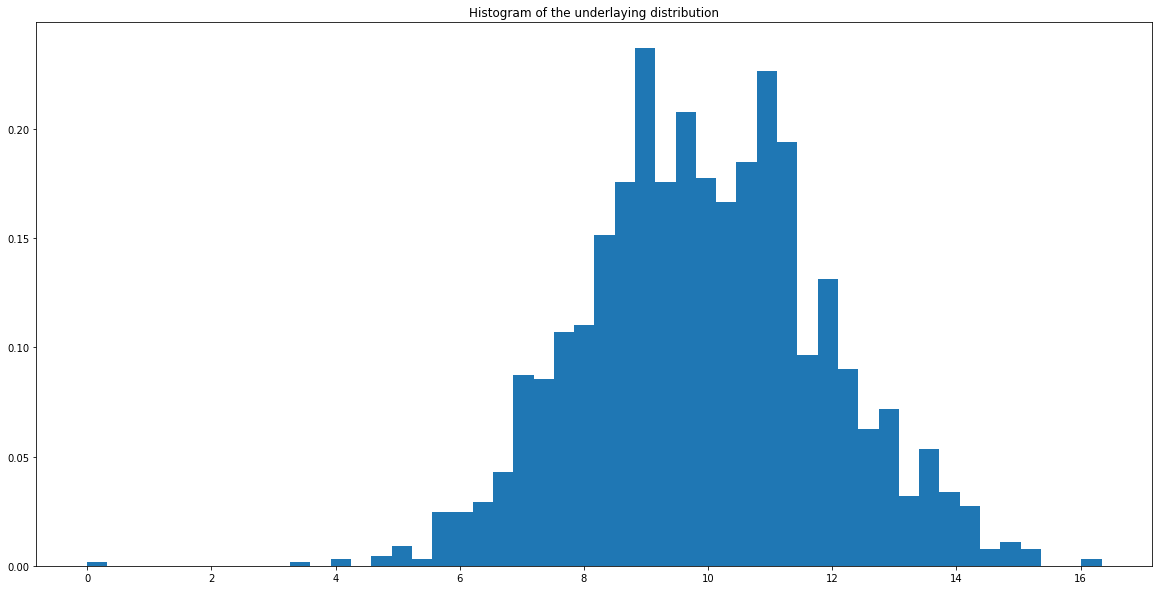

In [211]:
normal_dist = Normal_Distribution(10,2)
proposal = Proposal(beta = 2.3, pick = "random_walk")
sampler = Sampler(beta = 2.3, N = 2000, dimension = 1, target_distribution=normal_dist, proposal=proposal)

samples, _ = sampler.Non_Reversible_Metropolis_Hastings_Algo()

graph_maker = Graph_Maker(samples)
graph_maker.plot_1D_gaussian(10,2,True,"Finding the burn-in when sampling from a normal distribution(10,2) using a Non-Reversible sampler")

### 4 - Explore proposal densities (pCN and random walk) on the same problem Gaussian (10,2)

In [457]:
#Compare the asymptotic variance for the 2 estimators
N_s = [i for i in range(100,4000,200)]
variances = []

normal_dist = Normal_Distribution(10,2)
proposal_rw = Proposal(beta = 2.38, pick = "random_walk")
proposal_pCN = Proposal(beta = 1, pick = "pCN")

variances_pCN = []
variances_RW = []

for N in N_s:
    
    sampler = Sampler(beta = 2.38, N = N, dimension = 1, target_distribution=normal_dist, proposal=proposal_rw)
    samples_rw, _ = sampler.Reversible_Metropolis_Hastings_Algo()
    
    variance_analysis_rw = Variance_Analysis(samples_rw)
    variances_RW.append(variance_analysis_rw.variance_of_estimator())
    
    sampler = Sampler(beta = 1, N = N, dimension = 1, target_distribution=normal_dist, proposal=proposal_pCN)
    samples_pcn, _ = sampler.Reversible_Metropolis_Hastings_Algo()
    
    variance_analysis_pcn = Variance_Analysis(samples_pcn)
    variances_pCN.append(variance_analysis_pcn.variance_of_estimator())


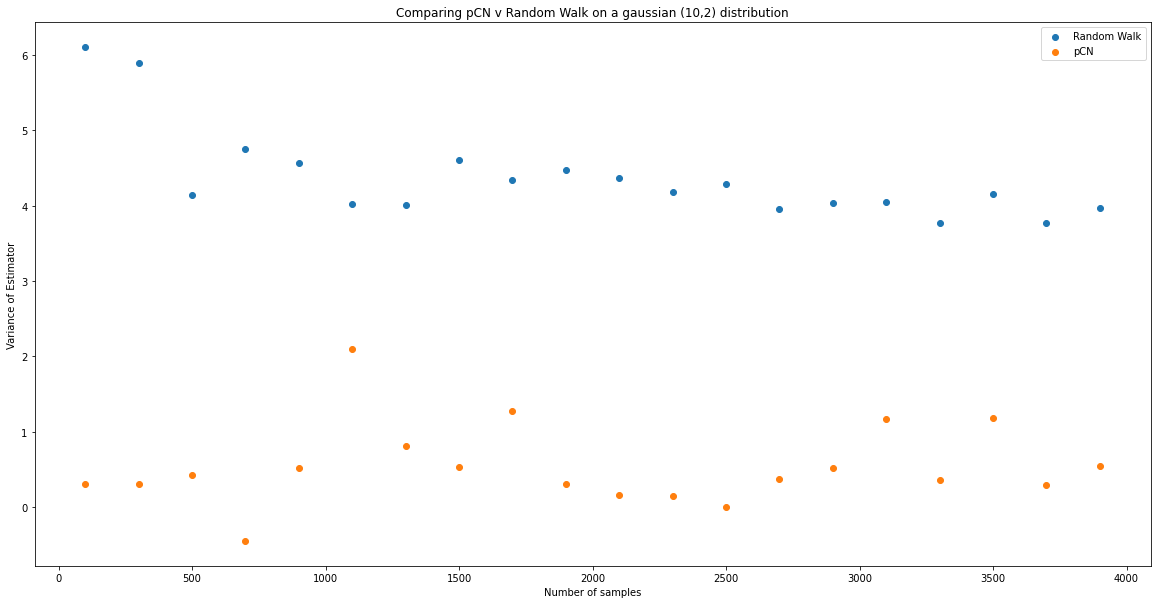

In [458]:
compare_proposals(N_s, variances_RW, variances_pCN, "Comparing pCN v Random Walk on a gaussian (10,2) distribution")

### 5 - Comparing Reversible vs Non-Reversible samplers on  a range of functions: Gaussian, Mixture Gaussians, Log Normal Distribution, Rosenbrook function, 2D-Gaussians

For both the reversible and non-reversible samplers all the test will have 4000 runs and the will use the same proposal density; random walk. The step size used will be with beta = 2.38. Therefore since we use a gamma random variable when we use non-reversible samplers we need to find the equivalent alpha and beta values such that the step size is equal the step size of a normal distribution when using beta = 2.38.http://abacus.gene.ucl.ac.uk/ziheng/pdf/2018ThawornwattanaBA.pdf

To caluculate this we need to note that the step size will not be the mean of a normal distrbution since in this case it would be simply equal to zero. However we need to take into account the value for the absolute step size instead. One can use to calcuate this the folded-normal distribution.

Mean = $${\displaystyle \mu _{Y}={\sqrt {\frac {2}{\pi }}}\sigma e^{-{\frac {\mu ^{2}}{2\sigma ^{2}}}}+\mu \left[1-2\Phi \left(-{\frac {\mu }{\sigma }}\right)\right]}$$

Where mu is the mean of the underlying normal distiburion in our case 0, and sigma the standard deviartion which in our case is beta. So we can reduce the mean to:

$${\displaystyle \mu _{Y}={\sqrt {\frac {2}{\pi }}}\sigma}$$

Which is equal to:

In [395]:
np.sqrt(2/np.pi)*2.38

1.8989652547108196

Therefore we need to tune our parameters alpha and beta to get the same value. The expected value of a gamma distribution is: alpha/beta

So we need to be : alpha/beta = 1.8989652547108196, we can let alpha = 1 and then beta we can let it be equal to 1/np.sqrt(2/np.pi)*2.38.

In [596]:
beta_R = 2.38
beta_Non_R = 1/(np.sqrt(2/np.pi)*2.38)
beta_Non_R = 0.15

#### 5.1 Gaussian Distribution

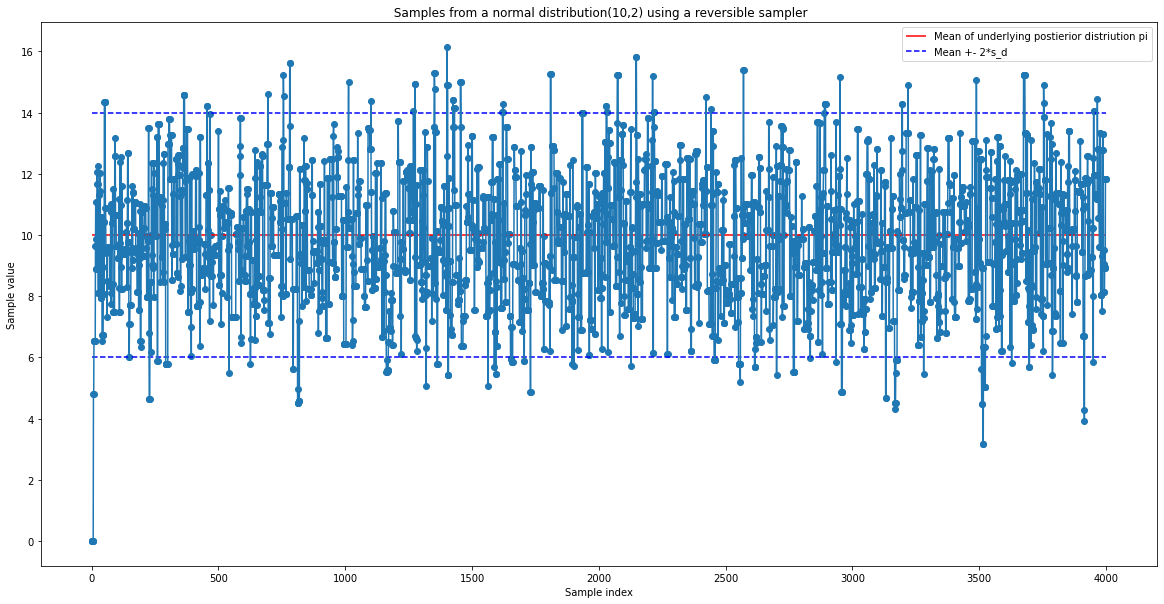

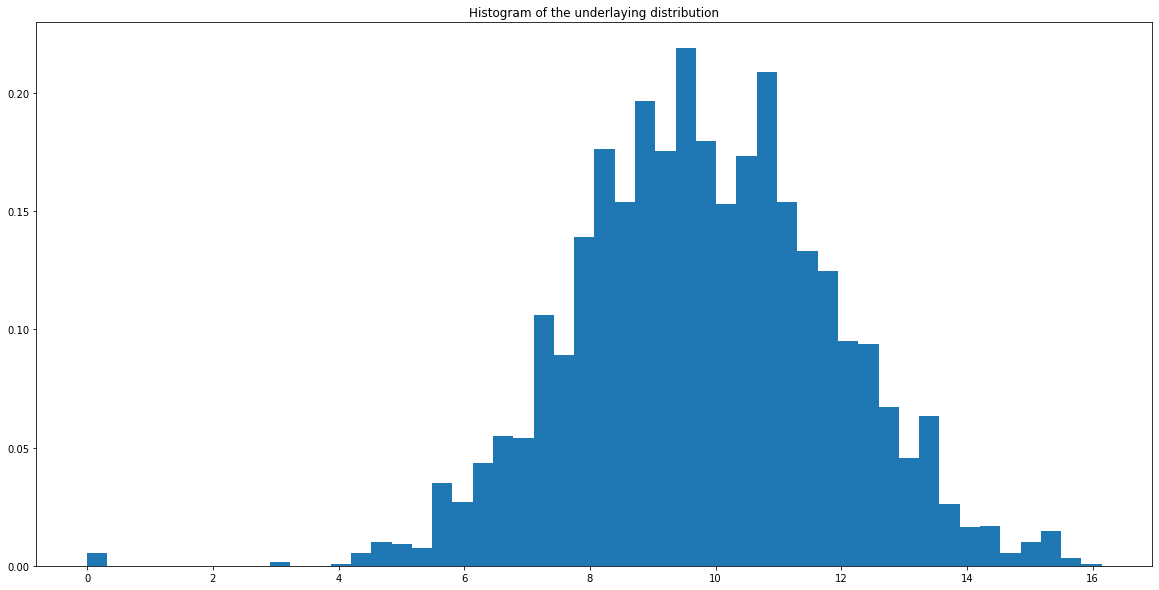

In [597]:
normal_dist = Normal_Distribution(10,2)
proposal = Proposal(beta = beta_R, pick = "random_walk")
sampler = Sampler(beta = beta_R, N = 4000, dimension = 1, target_distribution=normal_dist, proposal=proposal)

samples_reversible, _ = sampler.Reversible_Metropolis_Hastings_Algo()

graph_maker = Graph_Maker(samples_reversible)
graph_maker.plot_1D_gaussian(10,2,False," Samples from a normal distribution(10,2) using a reversible sampler")
graph_maker.plot_histogram("Histogram of the underlaying distribution")

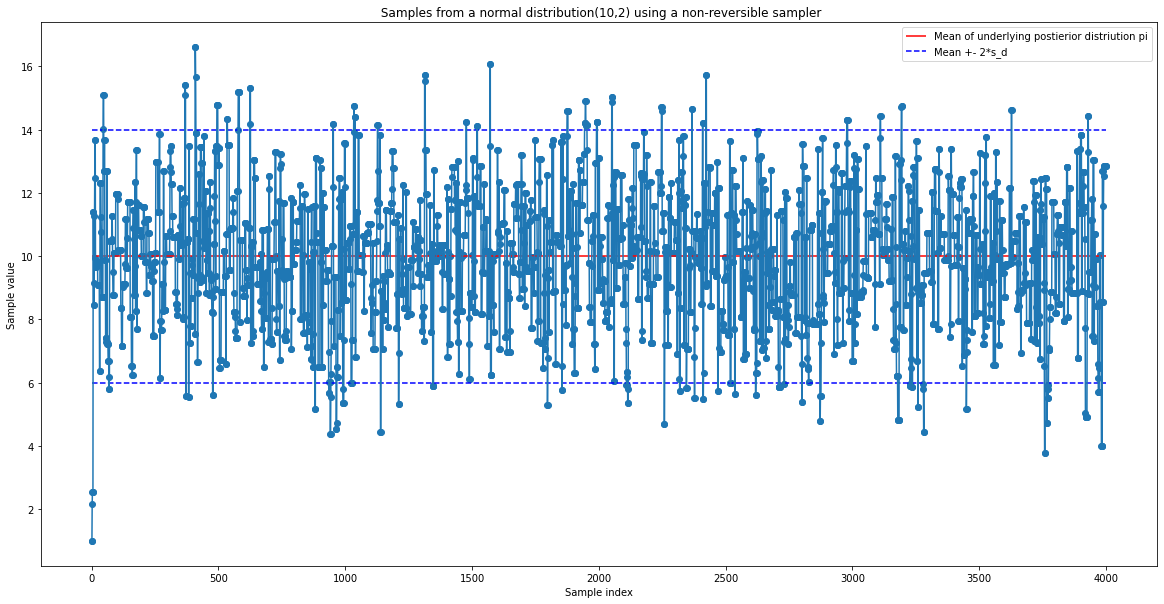

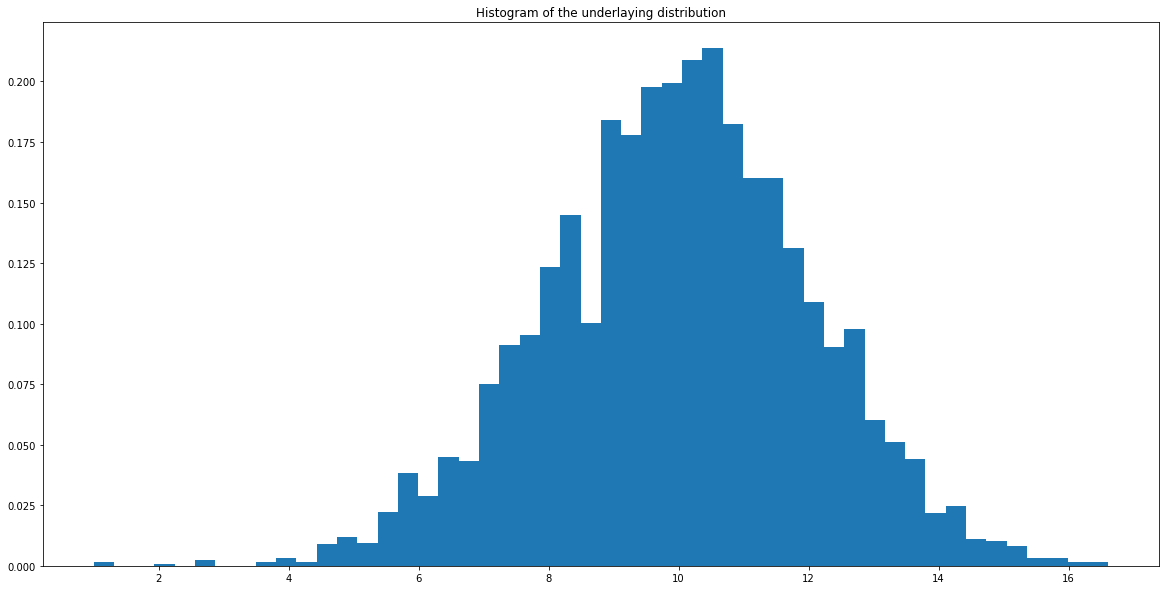

In [598]:
normal_dist = Normal_Distribution(10,2)
proposal = Proposal(beta = beta_Non_R, pick = "random_walk")
sampler = Sampler(beta = beta_Non_R, N = 4000, dimension = 1, target_distribution=normal_dist, proposal=proposal)

samples_non_reversible, _ = sampler.Non_Reversible_Metropolis_Hastings_Algo()

graph_maker = Graph_Maker(samples_non_reversible)
graph_maker.plot_1D_gaussian(10,2,False," Samples from a normal distribution(10,2) using a non-reversible sampler")
graph_maker.plot_histogram("Histogram of the underlaying distribution")

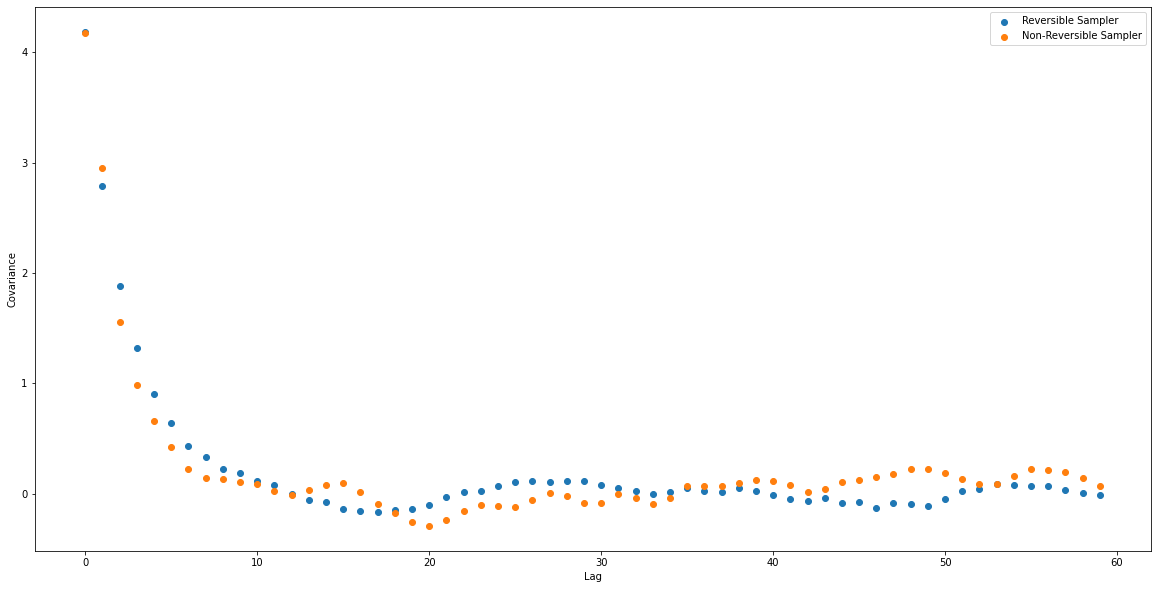

In [599]:
comparison = Compare_Reversible_Non_Reversible(samples_reversible,samples_non_reversible)
comparison.compare_lags(60)

#### 5.2 Log Normal Distribution

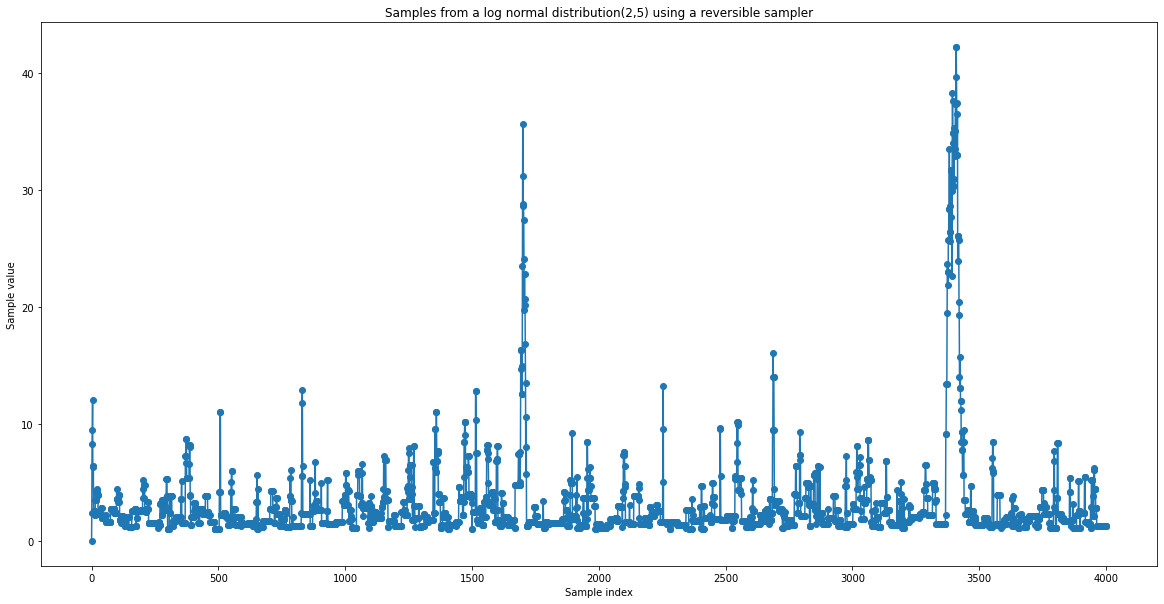

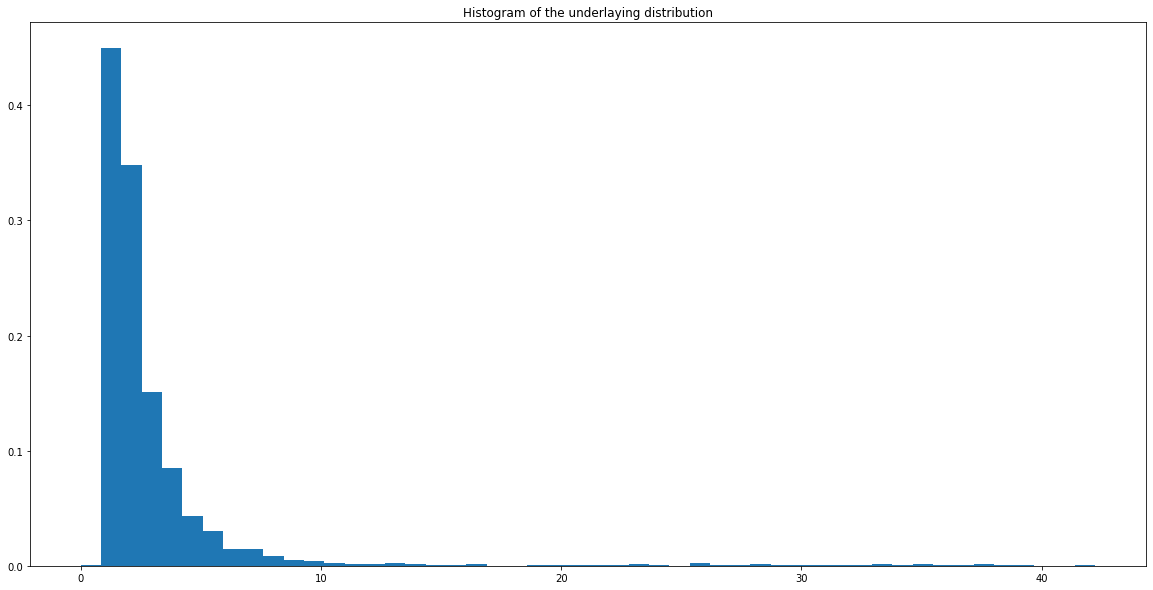

In [600]:
log_normal = Log_Normal_Distribution(1,1)
proposal = Proposal(beta = beta_R, pick = "random_walk")
sampler_log_normal = Sampler(beta = beta_R, N = 4000, dimension = 1, target_distribution=log_normal, proposal=proposal)

samples_reversible, _ = sampler_log_normal.Reversible_Metropolis_Hastings_Algo()

graph_maker = Graph_Maker(samples_reversible)
graph_maker.plot_samples("Samples from a log normal distribution(2,5) using a reversible sampler")
graph_maker.plot_histogram("Histogram of the underlaying distribution")

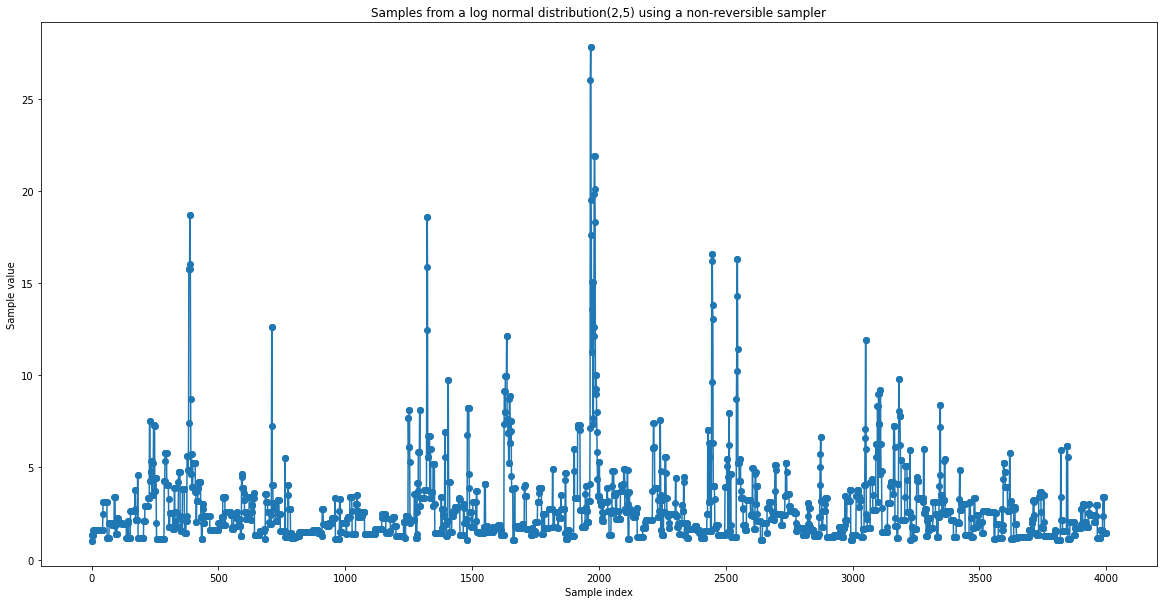

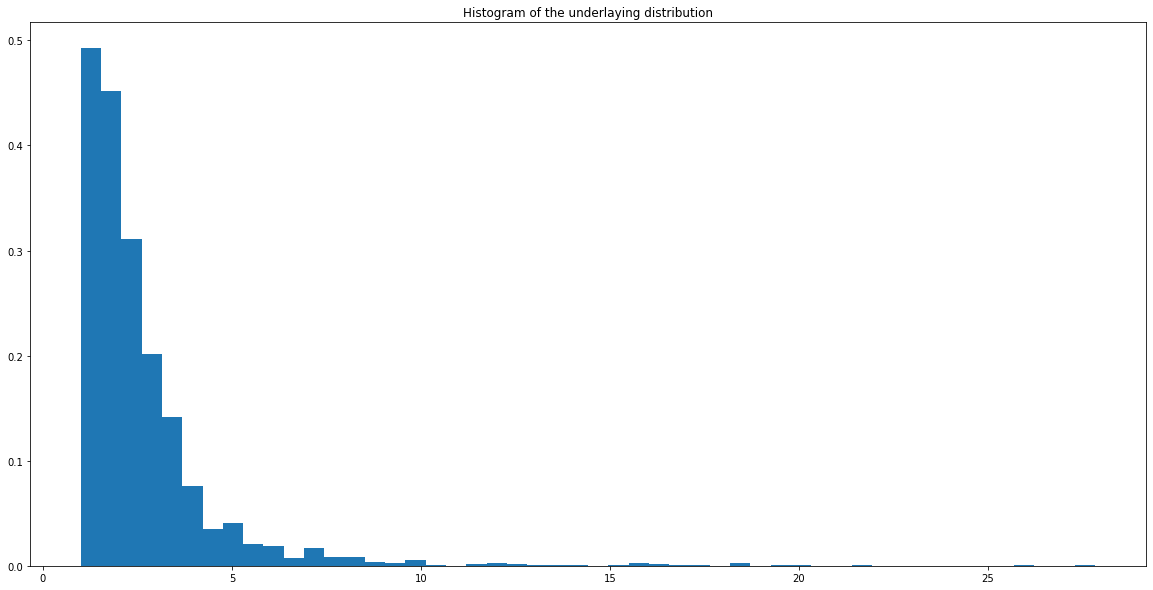

In [601]:
log_normal = Log_Normal_Distribution(1,1)
proposal = Proposal(beta = beta_Non_R, pick = "random_walk")
sampler_log_normal_ = Sampler(beta = beta_Non_R, N = 4000, dimension = 1, target_distribution=log_normal, proposal=proposal)

samples_non_reversible, _ = sampler_log_normal_.Non_Reversible_Metropolis_Hastings_Algo()

graph_maker = Graph_Maker(samples_non_reversible)
graph_maker.plot_samples("Samples from a log normal distribution(2,5) using a non-reversible sampler")
graph_maker.plot_histogram("Histogram of the underlaying distribution")

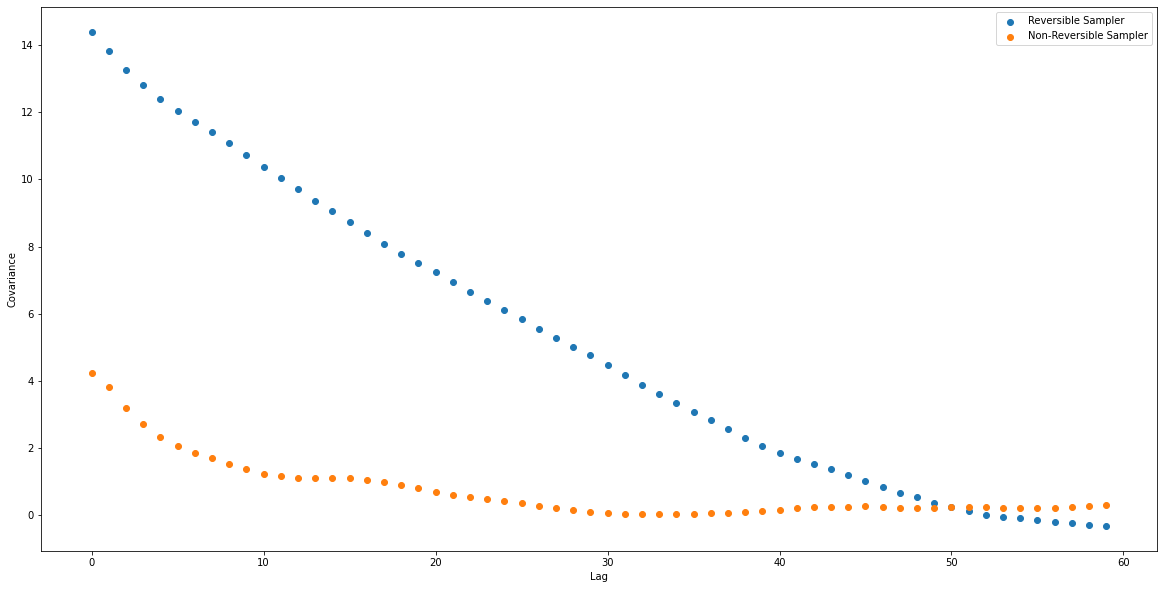

In [602]:
comparison = Compare_Reversible_Non_Reversible(samples_reversible,samples_non_reversible)
comparison.compare_lags(60)

#### 5.3 Gaussian Mixtures

In [603]:
pi_1 = stats.norm([5],[1])
pi_2 = stats.norm([-5],[1])

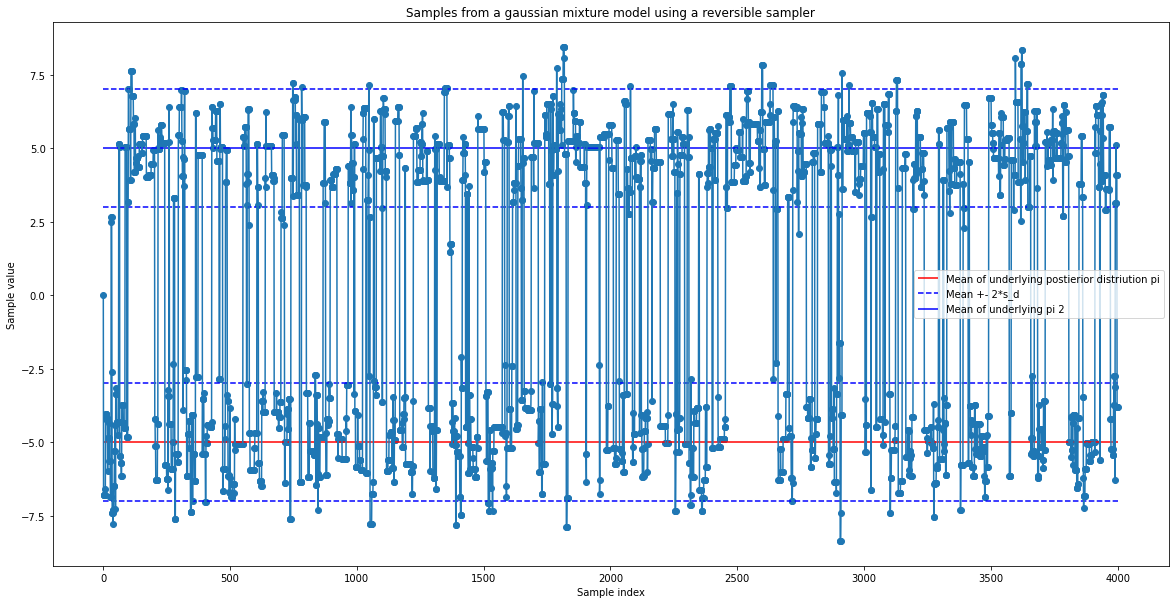

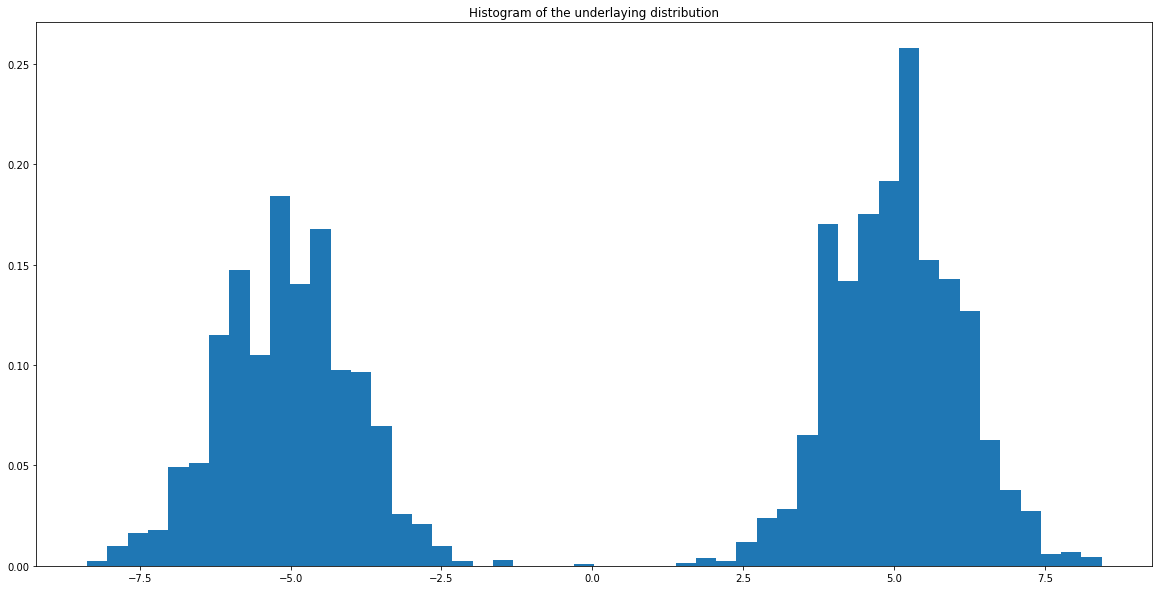

In [604]:
gaussian_mix = Gaussian_Mixture([pi_1,pi_2])
proposal = Proposal(beta = beta_R, pick = "random_walk")
sampler_gaussian_mix = Sampler(beta = beta_R, N = 4000, dimension = 1, target_distribution=gaussian_mix, proposal=proposal)

samples_reversible, _ = sampler_gaussian_mix.Reversible_Metropolis_Hastings_Algo()

graph_maker = Graph_Maker(samples_reversible)
graph_maker.plot_multivariate_gaussian([-5,5], [1,1], False,"Samples from a gaussian mixture model using a reversible sampler")
graph_maker.plot_histogram("Histogram of the underlaying distribution")

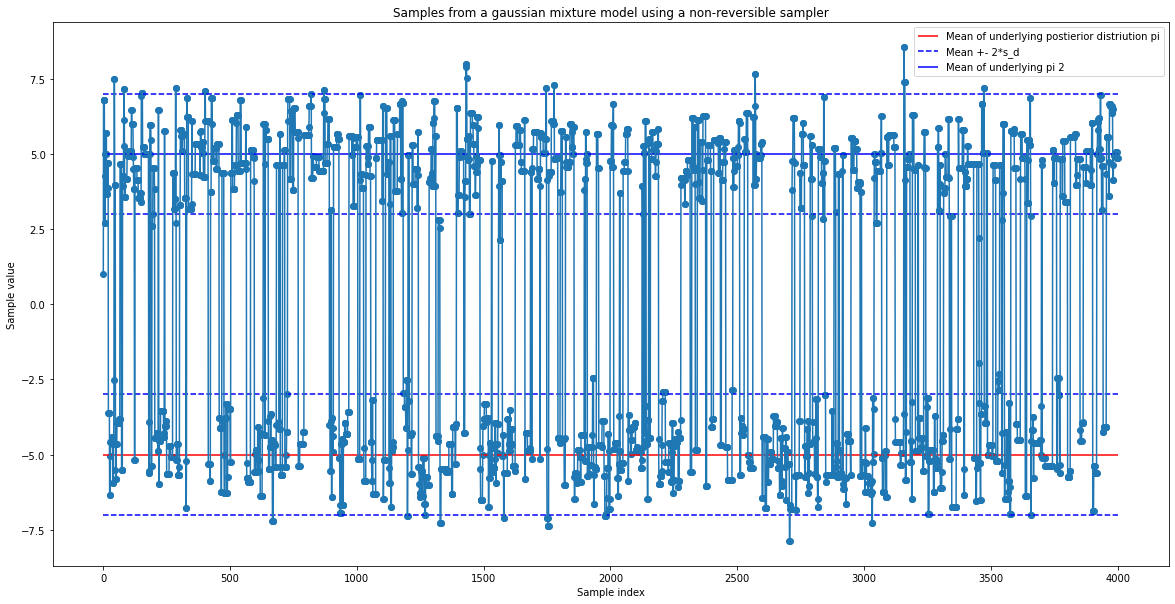

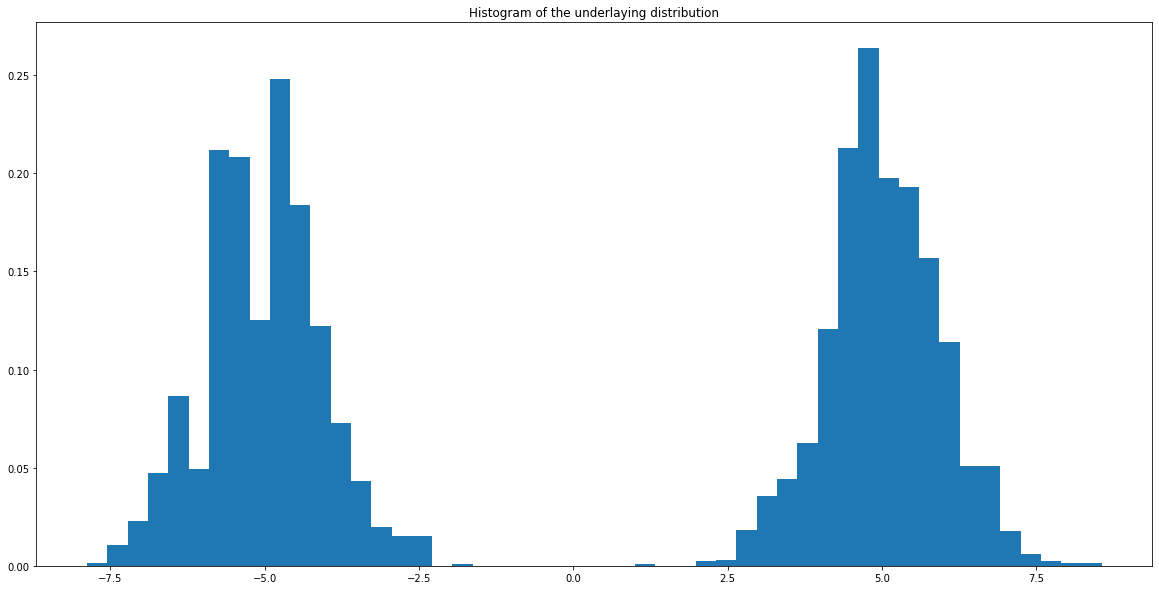

In [605]:
gaussian_mix = Gaussian_Mixture([pi_1,pi_2])
proposal = Proposal(beta = beta_Non_R, pick = "random_walk")
sampler_gaussian_mix_ = Sampler(beta = beta_Non_R, N = 4000, dimension = 1, target_distribution=gaussian_mix, proposal=proposal)

samples_non_reversible, _ = sampler_gaussian_mix_.Non_Reversible_Metropolis_Hastings_Algo()

graph_maker = Graph_Maker(samples_non_reversible)
graph_maker.plot_multivariate_gaussian([-5,5], [1,1], False,"Samples from a gaussian mixture model using a non-reversible sampler")
graph_maker.plot_histogram("Histogram of the underlaying distribution")

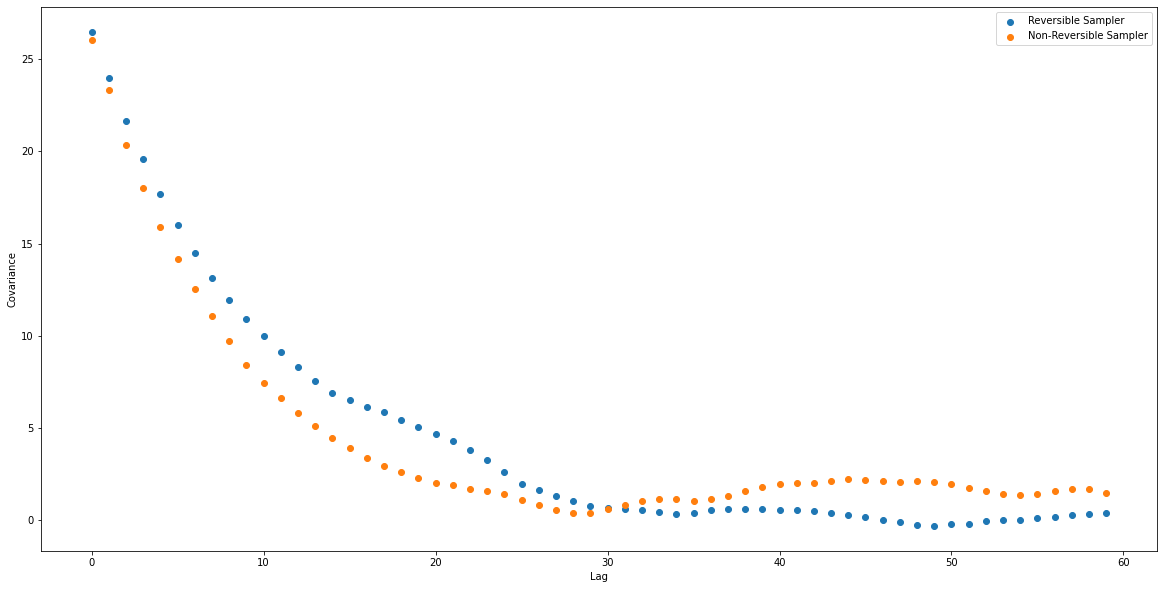

In [606]:
comparison = Compare_Reversible_Non_Reversible(samples_reversible,samples_non_reversible)
comparison.compare_lags(60)

#### 5.4 2D-Gaussian Distribution

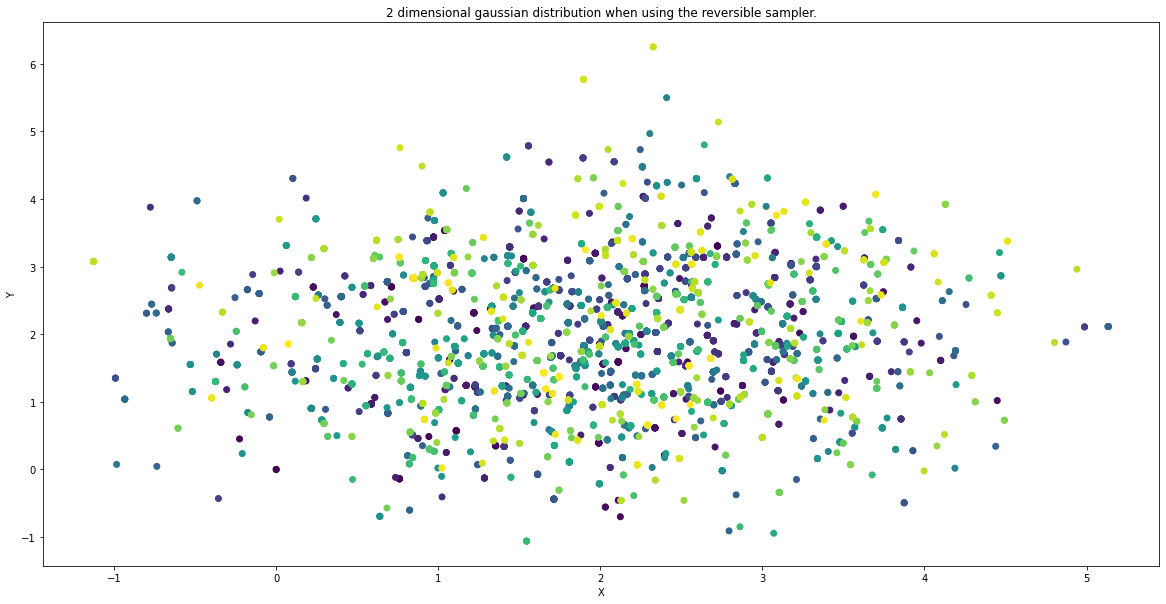

In [607]:
gaussian_2d = Multivariate_Gaussian([2,2],[[1,0],[0,1]])
proposal = Proposal(beta = beta_R, pick = "random_walk_2d")
sampler_gaussian_2d = Sampler(beta = beta_R, N = 4000, dimension = 2, target_distribution=gaussian_2d, proposal=proposal)

samples_reversible, _ = sampler_gaussian_2d.Reversible_Metropolis_Hastings_Algo()

graph_maker = Graph_Maker(samples_reversible)
graph_maker.plot_2D("2 dimensional gaussian distribution when using the reversible sampler.")

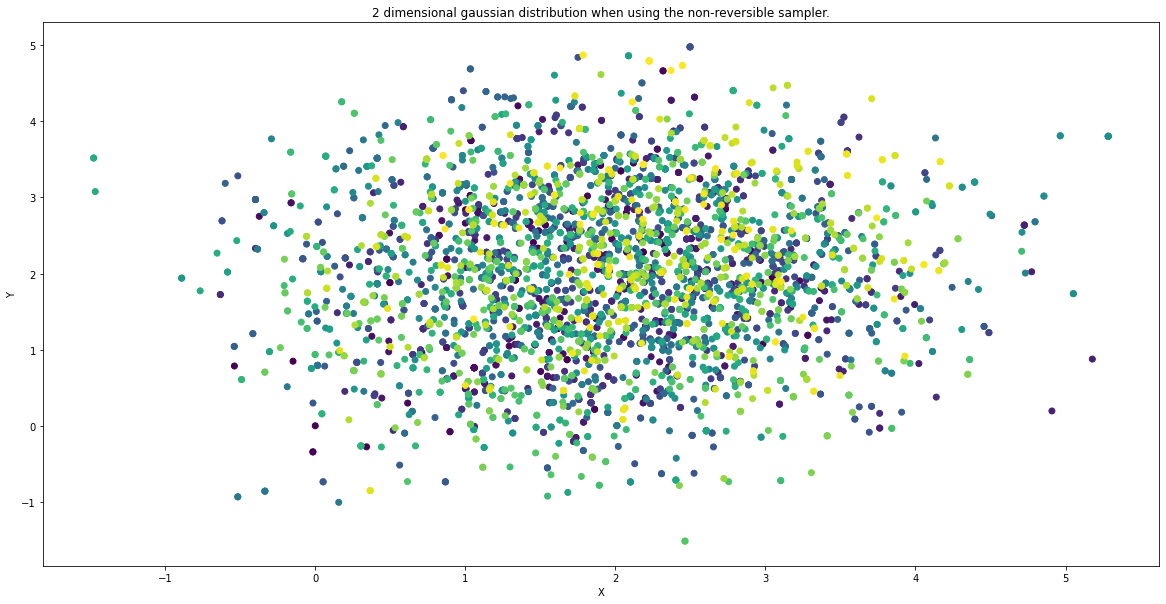

In [608]:
gaussian_2d = Multivariate_Gaussian([2,2],[[1,0],[0,1]])
proposal = Proposal(beta = beta_R, pick = "random_walk_2d")
sampler_gaussian_2d = Sampler(beta = beta_Non_R, N = 4000, dimension = 2, target_distribution=gaussian_2d, proposal=proposal)

samples_non_reversible, _ = sampler_gaussian_2d.Non_Reversible_Metropolis_Hastings_High_Dimensions(100)

graph_maker = Graph_Maker(samples_non_reversible)
graph_maker.plot_2D("2 dimensional gaussian distribution when using the non-reversible sampler.")

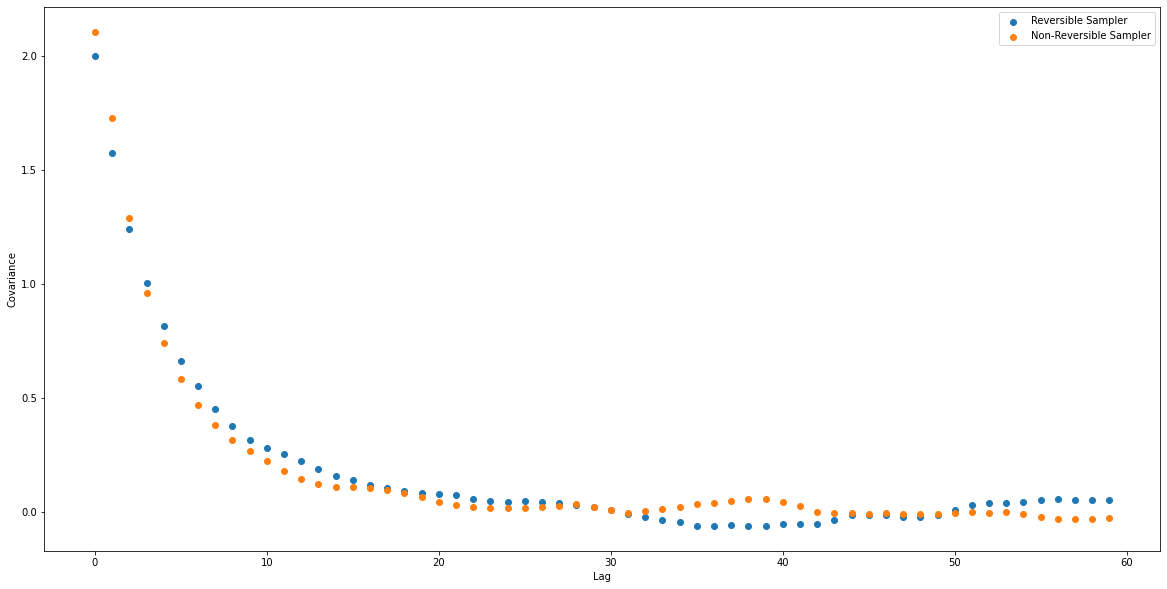

In [609]:
comparison = Compare_Reversible_Non_Reversible(samples_reversible,samples_non_reversible)
comparison.compare_lags(60)

#### 5.5 Rosenbrook function

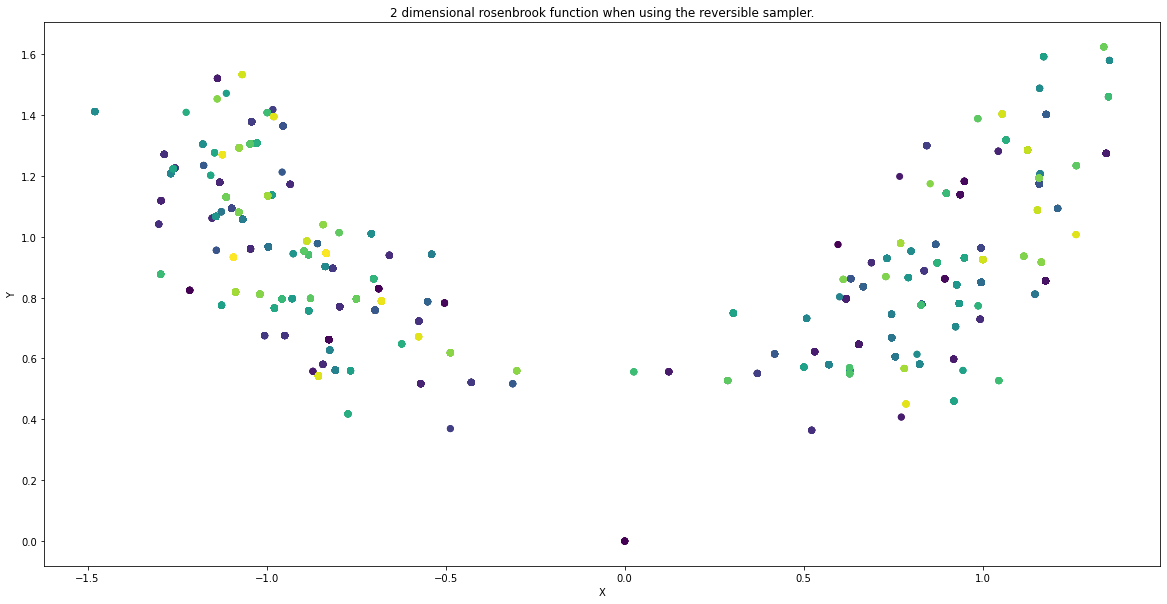

In [610]:
rosenbrook_2D = Rosenbrook_2D_Function(100,10)
proposal = Proposal(beta = beta_R, pick = "random_walk_2d")
sampler_rosenbrook_2D = Sampler(beta = beta_R, N = 10000, dimension = 2, target_distribution=rosenbrook_2D, proposal=proposal)

samples_reversible, _ = sampler_rosenbrook_2D.Reversible_Metropolis_Hastings_Algo()
graph_maker = Graph_Maker(samples_reversible)
graph_maker.plot_2D("2 dimensional rosenbrook function when using the reversible sampler.")

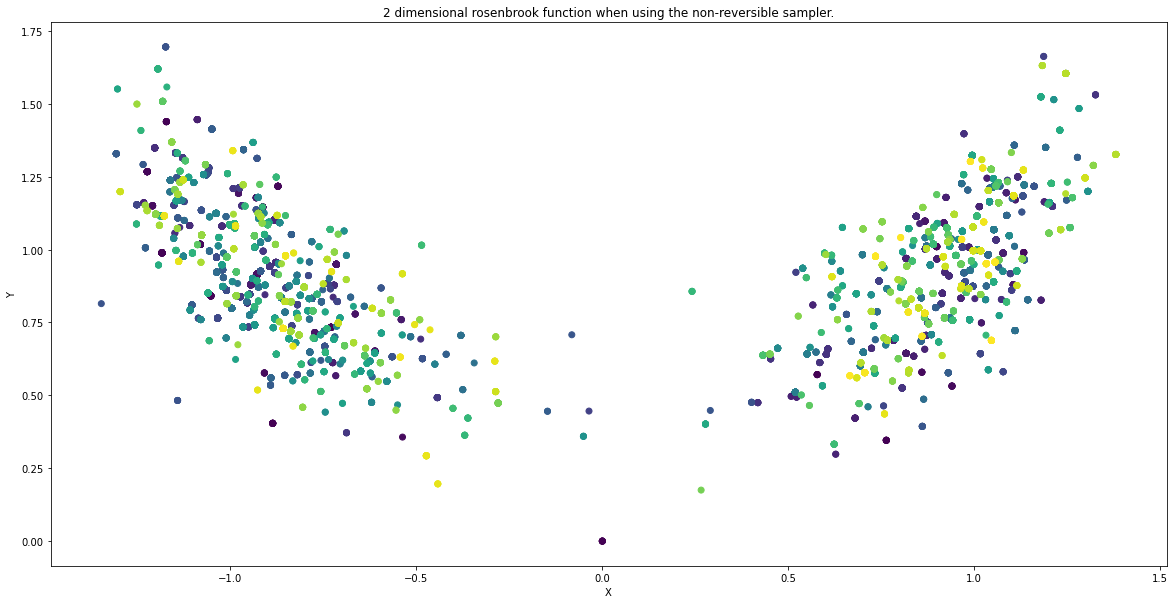

In [611]:
rosenbrook_2D = Rosenbrook_2D_Function(100,10)
proposal = Proposal(beta = beta_R, pick = "random_walk_2d")
sampler_rosenbrook_2D = Sampler(beta = beta_Non_R, N = 10000, dimension = 2, target_distribution=rosenbrook_2D, proposal=proposal)

samples_non_reversible, _ = sampler_rosenbrook_2D.Non_Reversible_Metropolis_Hastings_High_Dimensions(100)
graph_maker = Graph_Maker(samples_non_reversible)
graph_maker.plot_2D("2 dimensional rosenbrook function when using the non-reversible sampler.")

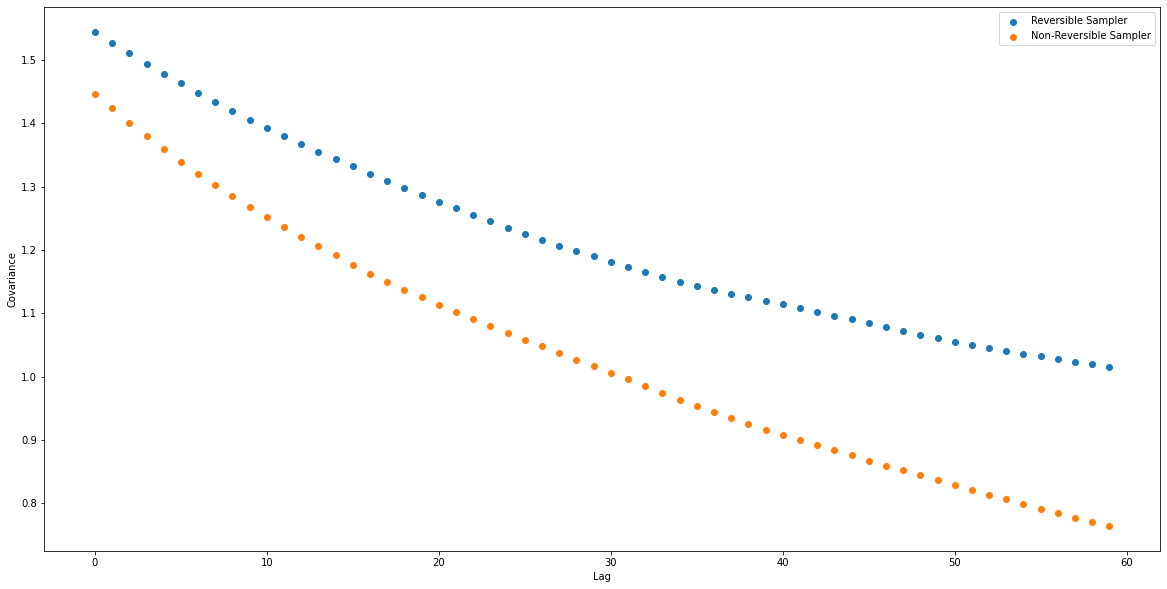

In [612]:
comparison = Compare_Reversible_Non_Reversible(samples_reversible,samples_non_reversible)
comparison.compare_lags(60)

### 6 - Imaging problems

In [4]:
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage
from scipy import stats

__all__ = \
    [
        "empty_true_color",
        "gaussian_filter",
        "get_bit_plane",
        "imhist",
        "imread",
        "imscale",
        "imshow",
        "imshow_reduced_color_depth",
        "imwrite",
        "linear_filter",
        "median_filter",
        "rank_filter",
        "zero_bit_plane"
    ]

In [5]:
def _img_a_cast(img_a, dtype, true_color=False):
    img_a = np.maximum(img_a, 0)
    img_a = np.minimum(img_a, 255)
    img_a = np.round(img_a, 0)
    img_a = np.array(img_a + 1.0e-6, dtype=dtype)
    if len(img_a.shape) == 2:
        if true_color:
            img_a_gs = np.zeros((img_a.shape[0], img_a.shape[1], 3),
                                dtype=dtype)
            for k in range(3):
                img_a_gs[:, :, k] = img_a
            return img_a_gs
        else:
            return img_a
    else:
        if len(img_a.shape) != 3 or img_a.shape[2] != 3:
            raise RuntimeError("Unexpected image type")
        return img_a

def imread(filename):
    img = PIL.Image.open(filename, "r")

    return np.array(img, dtype=np.int64)

def imscale(img_a, factor, interpolation="nearest"):
    M, N = img_a.shape[:2]
    M_scaled = int(max(round(M * factor, 0), 1) + 1.0e-6)
    N_scaled = int(max(round(N * factor, 0), 1) + 1.0e-6)

    img_a = _img_a_cast(img_a, dtype=np.uint8)
    img = PIL.Image.fromarray(img_a)
    img = img.resize((M_scaled, N_scaled),
                     resample={"nearest": PIL.Image.NEAREST,
                               "bilinear": PIL.Image.BILINEAR,
                               "bicubic": PIL.Image.BICUBIC,
                               "lanczos": PIL.Image.LANCZOS}[interpolation])

    return np.array(img, dtype=np.int64)

def imshow(img_a, new_figure=True):
    img_a = _img_a_cast(img_a, dtype=np.uint8, true_color=True)

    if new_figure:
        plt.figure()
    plt.imshow(img_a)
    plt.xticks([])
    plt.yticks([])

def linear_filter(img_a, W, **kwargs):
    img_a = _img_a_cast(img_a, dtype=np.int64)
    W = np.fliplr(np.flipud(W))

    if len(img_a.shape) == 2:
        img_filtered_a = scipy.ndimage.convolve(img_a, W, **kwargs)
    else:
        assert len(img_a.shape) == 3
        assert img_a.shape[2] == 3
        img_filtered_a = np.zeros_like(img_a)
        for k in range(3):
            img_filtered_a[:, :, k] = scipy.ndimage.convolve(
                img_a[:, :, k], W, **kwargs)

    return _img_a_cast(img_filtered_a, dtype=np.int64)

def gaussian_filter(img_a, sigma, **kwargs):
    img_a = _img_a_cast(img_a, dtype=np.int64)

    if len(img_a.shape) == 2:
        img_filtered_a = scipy.ndimage.gaussian_filter(
            img_a, sigma, **kwargs)
    else:
        assert len(img_a.shape) == 3
        assert img_a.shape[2] == 3
        img_filtered_a = np.zeros_like(img_a)
        for k in range(3):
            img_filtered_a[:, :, k] = scipy.ndimage.gaussian_filter(
                img_a[:, :, k], sigma, **kwargs)

    return _img_a_cast(img_filtered_a, dtype=np.int64)

In [6]:
class Sampler_Imaging():
    
    def __init__(self, beta, N, dimension, image, proposal, alpha=1):
        self.alpha = alpha
        self.beta = beta
        self.N = N
        self.dimension = dimension
        self.proposal = proposal
        self.target_distribution = Image_Target(image)
        self.image = image
    
    def Reversible_Metropolis_Hastings_Algo(self):
        """
        Implementation of Metropolis Hastings Algorithm.
        """
        # initalize
        u_0 = np.around(self.image.flatten())
        u_t = u_0

        samples = [u_0]
        list_acceptance_probaility = []
        
        proposal = self.proposal

        for t in range(self.N):
            
            # sample a proposal u′ from density q(u′|u(t)) 
            u_prime = np.around(proposal.get_random_variable(u_t))
            
            # proposal density q(u(t)|u′) and q(u′|u(t)) used in (3)
            # proposal_density_prime = proposal.get_dist(u_prime)
            # proposal_density_t = proposal.get_dist(u_t)
            
            # π(u′)q(u(t)|u′)
            numerator = self.target_distribution.pdf(u_prime)
            # π(u(t))q(u′|u(t))
            denominator = self.target_distribution.pdf(u_t)
            
            if numerator == 0:
                acceptance_probaility = 0
            elif denominator == 0:
                acceptance_probaility = 1
            else:
                acceptance_probaility = float(min([1,numerator/denominator]))
            
            list_acceptance_probaility.append(acceptance_probaility)
            rv = np.random.uniform(0,1,1)
            if rv <= acceptance_probaility:
                #Accept
                u_t = u_prime
                samples.append(u_t)
            else:
                #Reject
                u_t = u_t
                samples.append(u_t)
    
        return samples, list_acceptance_probaility

In [7]:
class Image_Target():
    
    def __init__(self, image):
            self.image = image
            self.n = image.shape[0]
            self.flatten_image = image.flatten()
    
    def prior_TV(self, x):
        x = x.reshape((self.n,self.n))
        sum = 0
        for i in range(self.n-1):
            for j in range(self.n-1):
                sum = sum + np.sqrt(np.abs(x[i+1,j]-x[i,j])**2 + np.abs(x[i,j+1]-x[i,j])**2)
        return sum
    
    def prior_J_TV(self, x):
        n = self.n
        X = x.reshape((self.n,self.n))
        first = np.array([-1]+[1]+[0 for i in range(n-2)])
        last = np.array([0 for i in range(n-2)]+[-1]+[1])
        D = first
        for i in range(n-2):
            D_i = np.array([0 for i in range(i)]+[-1,0,1]+[0 for i in range(n-3-i)])
            D = np.vstack((D,D_i))

        D = np.vstack((D,last))

        n, m = D.shape
        X_D_t = X@D.T
        D_X = D@X

        sum = 0
        for i in range(m):
            for j in range(n):
                sum = sum + np.sqrt(((X_D_t)[i,j])**2 + ((D_X)[i,j])**2)
        return sum
    
    def likelihood(self, x):
        
        return stats.multivariate_normal(x, np.eye(self.n*self.n)).pdf(self.flatten_image)
            
    def pdf(self, x):
        """
        Posterior distribution of image, gets the pdf of a new point x, which in this case is a new image.
        """
        return self.prior_J_TV(x)*(np.exp(-1/2*(np.linalg.norm(self.flatten_image-x))**2))

In [11]:
import os 
filename = os.getcwd()

In [12]:
image_camera = imread(filename+"/cameraman.png")

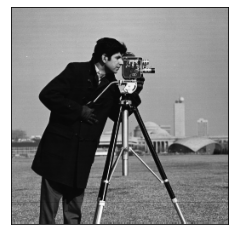

In [13]:
imshow(image_camera)

#### 6.1 De-Noising

(None, None)

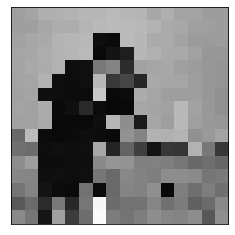

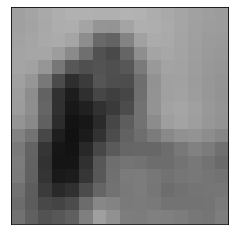

In [14]:
image_camera_scaled = imscale(image_camera,1/16)
img_noisy_scaled = gaussian_filter(image_camera_scaled,1)

imshow(image_camera_scaled), imshow(img_noisy_scaled)

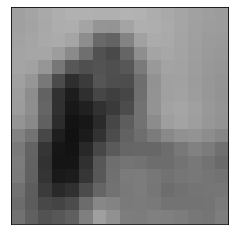

In [15]:
# You can flatten and then reshape to get the same image.
test = img_noisy_scaled.flatten()
imshow(test.reshape(16,16))

In [19]:
target_distribution = Image_Target(img_noisy_scaled)
proposal = Proposal(0.2,"random_walk_nd")

u_0 = np.around(img_noisy_scaled.flatten())
u_t = u_0

# sample a proposal u′ from density q(u′|u(t)) 
u_prime = np.around(proposal.get_random_variable(u_t))
u_prime_1 = np.around(proposal.get_random_variable(u_t))
u_prime_2 = np.around(proposal.get_random_variable(u_t))
u_prime_3 = np.around(proposal.get_random_variable(u_t))

print(target_distribution.pdf(u_prime),target_distribution.pdf(u_prime_1),
      target_distribution.pdf(u_prime_2), target_distribution.pdf(u_prime_3), target_distribution.pdf(u_t))

1810.3388826809862 665.7999714452993 403.9861470468232 1098.3754223464975 8115.483566443877


In [17]:
proposal = Proposal(2.3,"random_walk_nd")
proposal.random_walk_nd([2,4])

#### 6.1a Finding the best beta value for our problem

In [142]:
dimension = len(img_noisy_scaled.flatten())

beta_s = list(np.linspace(0.1,3,30))
list_a_p = []

for beta in beta_s:
    print(beta)
    proposal = Proposal(beta = beta, pick = "random_walk_nd")
    sampler = Sampler_Imaging(beta = beta, N = 100, dimension = dimension, image=img_noisy_scaled, proposal=proposal)
    _, a = sampler.Reversible_Metropolis_Hastings_Algo()
    average_acceptance_probabity = np.mean(a)
    list_a_p.append(average_acceptance_probabity)

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.7999999999999999
0.8999999999999999
0.9999999999999999
1.0999999999999999
1.2
1.3
1.4
1.5
1.5999999999999999
1.7
1.8
1.9
2.0
2.0999999999999996
2.1999999999999997
2.3
2.4
2.5
2.6
2.6999999999999997
2.8
2.9
3.0


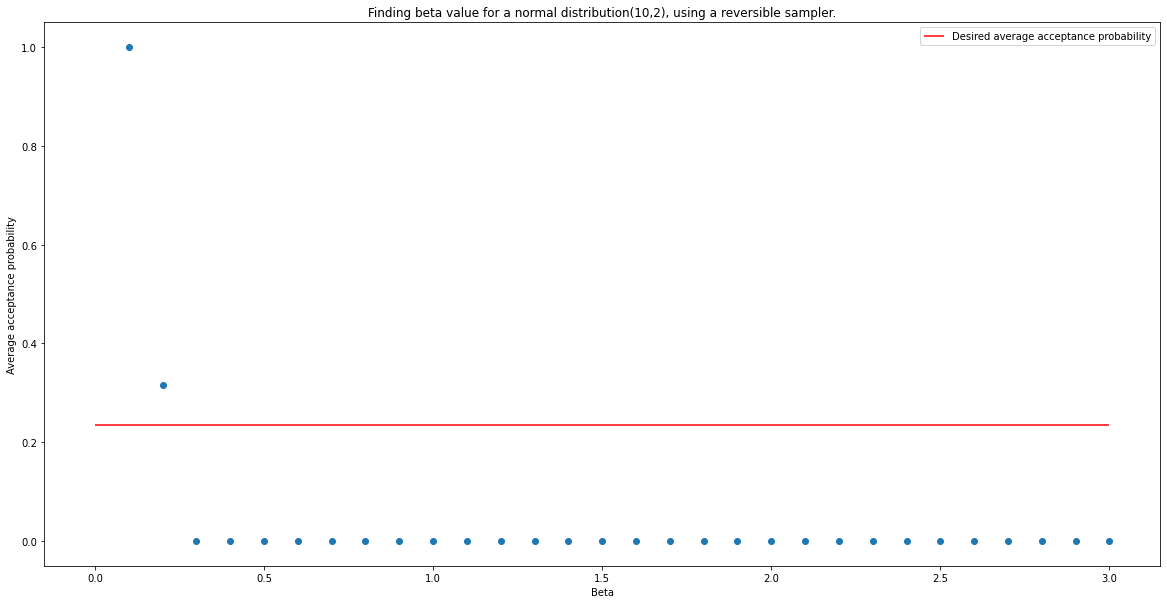

In [143]:
finding_beta(beta_s, list_a_p, "Finding beta value for a normal distribution(10,2), using a reversible sampler.")

#### 6.1b Using MHA to sample potential images

In [101]:
beta_R = 2
beta_Non_R = 1/(np.sqrt(2/np.pi)*2.38)
beta_Non_R = 0.15

In [105]:
dimension = len(img_noisy_scaled.flatten())

target_distribution = Image_Target(img_noisy_scaled)
proposal = Proposal(beta = beta_R, pick = "random_walk_nd")
sampler_image = Sampler_Imaging(beta = beta_R, N = 5000, dimension=dimension, image=img_noisy_scaled, proposal=proposal)

samples_reversible, _ = sampler_image.Reversible_Metropolis_Hastings_Algo()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

#### 6.1c MAP to find the most likey image from the samples.

In [126]:
def MAP(samples_reversible, target_distribution):
    max_value = 0
    best_image = samples_reversible[0]
    
    for image in samples_reversible:
        if target_distribution.pdf(image) > max_value:
            max_value = target_distribution.pdf(image)
            best_image = image
    
    return image

def CM(samples_reversible):
    image_1 = samples_reversible[0]
    for image in samples_reversible[1:]:
        image_1 = image_1 + image
    return (1/len(samples_reversible))*(image_1)

Original Noisy Image:


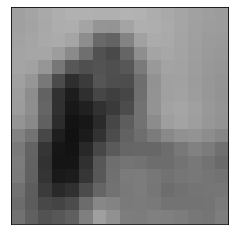

In [127]:
print("Original Noisy Image:")
imshow(img_noisy_scaled)

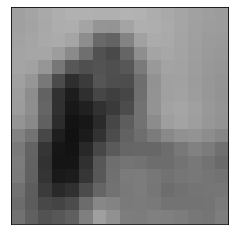

In [128]:
print("Reconstructed Image with CM:")
best_image = CM(samples_reversible)
imshow(best_image.reshape(16,16))

Reconstructed Image:


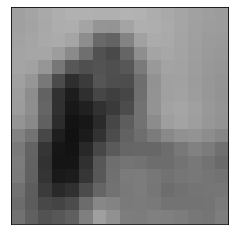

In [122]:
print("Reconstructed Image with MAP:")
best_image = MAP(samples_reversible, target_distribution)
imshow(best_image.reshape(16,16))

Target Image:


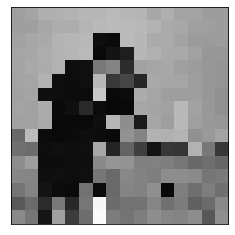

In [117]:
print("Target Image:")
imshow(image_camera_scaled)